In [1]:
import torch
# import torch.fft
import torch.nn.functional as F
# import torchvision.transforms as transforms
from PIL import Image
# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import scipy.ndimage as ndimage

# 设置pytorch打印选项
torch.set_printoptions(
    threshold=1024,         # 最大显示元素数量为10
    linewidth=320,        # 每行的最大字符数为120
    precision=2,          # 小数点后的数字精度为4
    edgeitems=20,          # 每行显示的边缘元素数量为5
    sci_mode=False        # 不使用科学计数法
)

from dataprocess.sirst import IRSTD1kDataset
# from dataprocess.sirst_point import IRSTD1kDataset
import torch.utils.data as Data
import yaml
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import cv2

# from utils.DenseCRF import pro_crf
from net.attentionnet import attenMultiplyUNet_withloss
 
cfg_path = 'cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

# trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=512, pt_label=True, pseudo_label=False, augment=False,cfg=cfg)
# train_data_loader = Data.DataLoader(trainset, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
import torch.utils.data as Data
import torchvision.transforms as transforms

import cv2
import os
import os.path as osp
import matplotlib.pyplot as plt

import random
import scipy.ndimage
import numpy as np


class RandomResize:
    def __init__(self, min_size, max_size):
        self.min_size = min_size
        self.max_size = max_size

    def __call__(self, img):
        # 随机选择一个目标大小
        target_size = random.randint(self.min_size, self.max_size)
        # 使用 Resize 调整图像大小
        resize_transform = transforms.Resize((target_size, target_size))
        return resize_transform(img)


class IRSTD1kDataset(Data.Dataset):
    """
    Return: Single channel
    """

    def __init__(
        self,
        base_dir=r"W:/DataSets/Infraid_datasets/IRSTD-1k",
        mode="train",
        base_size=256,
        pt_label=False,
        pseudo_label=False,
        augment=True,
        turn_num=0,
        target_mix = False,
        cfg=None
    ):
        assert mode in ["train", "test"]

        if mode == "train":
            self.data_dir = osp.join(base_dir, "trainval")
        elif mode == "test":
            self.data_dir = osp.join(base_dir, "test")
        else:
            raise NotImplementedError
        
        self.mode = mode
        self.cfg = cfg
        self.base_size = base_size
        self.pt_label = pt_label
        self.pseudo_label = pseudo_label
        self.aug = augment
        self.turn_num = turn_num
        self.target_mix = target_mix
        self.names = []
        for filename in os.listdir(osp.join(self.data_dir, "images")):
            if filename.endswith("png"):
                self.names.append(filename)

        self.augment_test = transforms.Compose([
            transforms.Resize((self.base_size, self.base_size), interpolation=transforms.InterpolationMode.NEAREST)
        ])

        self.augment_train = transforms.Compose([
            transforms.RandomResizedCrop(
                base_size,
                scale=(0.8, 1.0),
                antialias=True),  # 在给定的scale范围内随机缩放并裁剪
            transforms.RandomAffine(degrees=180, translate=(0.3, 0.3)),
            transforms.RandomHorizontalFlip(),  # 随机水平翻转
        ])
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=5, sigma=(0.5, 0.8)) if target_mix else None
        self.target_trans = transforms.Compose([
            # transforms.RandomResizedCrop(
            #     64,
            #     scale=(0.2, 1.0),
            #     antialias=True),  # 在给定的scale范围内随机缩放并裁剪
            transforms.RandomAffine(degrees=180, translate=(0.3, 0.3)),
            transforms.RandomHorizontalFlip()])  # 随机水平翻转
        self.gaussian_filter3 = transforms.GaussianBlur(kernel_size=3, sigma=(0.3, 0.5)) if target_mix else None
        # self.gaussian_filter9 = transforms.GaussianBlur(kernel_size=9, sigma=(0.3, 0.5)) if target_mix else None

    def __getitem__(self, i):
        name = self.names[i]
        img_path = osp.join(self.data_dir, "images", name)
        pseudo_label_path = osp.join(self.data_dir, f'pixel_pseudo_label{self.turn_num}', name)
        label_path = osp.join(self.data_dir, "masks", name)
        if self.pseudo_label:
            img, mask, pseudo_label = cv2.imread(img_path, 0), cv2.imread(label_path, 0), cv2.imread(pseudo_label_path, 0)

            img = torch.from_numpy(img).type(torch.float32)
            mask = torch.from_numpy(mask).type(torch.float32)
            pseudo_label = torch.from_numpy(pseudo_label).type(torch.float32)
            
            img, mask, pseudo_label = self.augment_test(img.unsqueeze(0)), self.augment_test(mask.unsqueeze(0)), self.augment_test(pseudo_label.unsqueeze(0))
            data = (img, mask, pseudo_label)
        else:
            img, mask= cv2.imread(img_path, 0), cv2.imread(label_path, 0)

            img = torch.from_numpy(img).type(torch.float32)
            mask = torch.from_numpy(mask).type(torch.float32)
            img, mask = self.augment_test(img.unsqueeze(0)), self.augment_test(mask.unsqueeze(0))

            data = (img, mask)
        data = torch.cat(data, dim=0) 

        data_aug = self.augment_train(data) if self.mode == "train" and self.aug else data

        data_aug = data_aug / 255.0

        data_aug = data_aug.unsqueeze(1)

        if self.pt_label:
            pt_label = self.__mask2point(data_aug[1])
            # data_aug = torch.concatenate((data_aug,pt_label.unsqueeze(0)),dim=0)
            data_aug[1] = pt_label
        # row_num = 4
        # col_num = 4
        # fig, axes = plt.subplots(row_num, col_num, figsize=(col_num*4, row_num*4))
        # for i in range(row_num):
        #     axes[i, 0].imshow(data_aug[0,0].numpy(), cmap='gray')
        #     axes[i, 1].imshow(data_aug[1,0].numpy(), cmap='gray')
        #     axes[i, 2].imshow(data_aug[2,0].numpy(), cmap='gray')
        #     axes[i, 3].imshow(data_aug[3,0].numpy(), cmap='gray')
        # plt.tight_layout()
        # plt.show()
        # a = input()
        elif self.target_mix:
            edge_path = osp.join(self.data_dir, "canny_edge")
            name = self.names[i]
            edge = cv2.imread(osp.join(edge_path, name), 0)
            edge = torch.from_numpy(edge).type(torch.float32)
            edge = self.augment_test(edge.unsqueeze(0)) / 255.0

            target_path = osp.join(self.data_dir, "perfect_target")
            target_names = os.listdir(target_path)
            target_name = random.choice(target_names)
            target = cv2.imread(osp.join(target_path, target_name), 0)
            target = torch.from_numpy(target).type(torch.float32) / 255.0

            data_aug[0], data_aug[1] = self.__mix_target(data_aug[0], data_aug[1], edge[0], target)
        if self.pseudo_label:
            return data_aug[0], data_aug[1], data_aug[2]
        else:
            return data_aug[0], data_aug[1]

    def __len__(self):
        return len(self.names)
    
    def __mask2point(self, mask):
        # 将mask转换为numpy数组以便处理
        mask_array = np.array(mask[0])
        # 使用连通组件分析找到所有独立的目标区域
        labels, num_features = scipy.ndimage.label(mask_array > 0.9)

        pts_label = torch.zeros_like(mask, dtype=torch.float32)

        for label_id in range(1, num_features + 1):
            # 获取当前连通组件的位置
            pos = np.where(labels == label_id)
            
            if len(pos[0]) == 0:
                continue 

            # 计算目标区域的边界框
            top_left_x = min(pos[1])
            top_left_y = min(pos[0])
            bottom_right_x = max(pos[1])
            bottom_right_y = max(pos[0])

            # 计算正方形的中心点, 并加随机数，产生手工标注的误差效果
            center_x = (top_left_x + bottom_right_x) // 2
            center_y = (top_left_y + bottom_right_y) // 2
            # center_x = (top_left_x + bottom_right_x) // 2 + torch.randint(-2, 3, (1,))
            # center_y = (top_left_y + bottom_right_y) // 2 + torch.randint(-2, 3, (1,))

            # center_x = np.clip(center_x, 0, 255)
            # center_y = np.clip(center_y, 0, 255)
            pts_label[0, center_y, center_x] = 1.0

        return pts_label

    def __mix_target(self, img, mask, edge, target):
        """
        Mix the target with image and mask.
        Target is from perferct generated pesudo label, with no dissociated pixels.
        Mixing includs the following steps:
        1. Find the proper position for the target where the img is complex. Furthermore, complex area means there are many edges.
        2. Mix the target with image in proper way which means the border of the target and background is smooth.
        3. Make mask according to the new and original target.
        """
        # target trasform
        target = RandomResize(16, 64)(target.unsqueeze(0))
        target = self.target_trans(target)
        _, iH, iW = img.shape
        _, tH, tW = target.shape
        # target_blured = self.gaussian_blur(target.unsqueeze(0))
        # # plt.figure(figsize=(12, 12))
        # # plt.imshow(target_blured[0], cmap='gray')
        # # plt.show()
        # # a = input()

        # Step 1, find an area where the complexicity is mid-level.
        h_idx, w_idx = self.__random_position(edge, mask)
        ## coordinate of the target 
        x1, x2 = max(w_idx - tW // 2, 0), min(w_idx + (tW - tW // 2), iW-1)
        y1, y2 = max(h_idx - tH // 2, 0), min(h_idx + (tH - tH // 2), iH-1)
        ## part of the target
        tx1, tx2 = tW // 2 - (w_idx - x1), x2 - w_idx + tW // 2
        ty1, ty2 = tH // 2 - (h_idx - y1), y2 - h_idx + tH // 2
        # mix the target with image(simple way)
        img_part = img[0, y1:y2, x1:x2].clone()
        target = target[0, ty1:ty2, tx1:tx2]
        if target.max() <= 0.1:
            return img, mask
        target_blured = self.gaussian_blur(target.unsqueeze(0))[0]
        img_accor_part = img_part * (target_blured > 0.)
        # plt.figure(figsize=(20, 5))
        # plt.subplot(141), plt.imshow(target, cmap='gray')
        # plt.subplot(142), plt.imshow(target_blured, cmap='gray')
        # plt.subplot(143), plt.imshow(img_accor_part, cmap='gray')
        # plt.subplot(144), plt.imshow(img[0, y1:y2, x1:x2], cmap='gray')
        # plt.show()
        # a = input()
        ## contrast modification
        target_mean = target[target > 0.1].mean()
        img_accor_part_mean = img_accor_part[target > 0.1].max()
        img_accor_part_mean = img_accor_part_mean if img_accor_part_mean > 0.1 else 0.1
        enhanced_ratio = random.uniform(1.2, 1.4)    # super parameter
        img_accor_part_mean = img_accor_part_mean * enhanced_ratio
        adaptive_intensity_ratio = (enhanced_ratio - 1) * img_accor_part_mean / target_mean
        target_enbeded = target * adaptive_intensity_ratio + img_accor_part_mean * (target > 0.) 
        ## mixing
        target_area = self.gaussian_blur(target_enbeded.unsqueeze(0))[0]
        traget_blured = self.gaussian_blur((target_enbeded + (target_enbeded <= 0.1) * img_part).unsqueeze(0))[0] * (target_area > 0.1)

        # anti_blured_target = self.gaussian_blur((target_blured > 0.1).type(torch.float32).unsqueeze(0))[0]
        # img[0, y1:y2, x1:x2] = (target_enbeded * (target > 0.1) + mixing_blured * (target <= 0.1)) * anti_blured_target + img_part * (1-anti_blured_target)
        # img[0, y1:y2, x1:x2] = (target_blured * (target_edge_blured > 0.2) + target_edge_blured * (target_edge_blured <= 0.2))* anti_blured_target + img_part * (1-anti_blured_target)
        # img[0, y1:y2, x1:x2] = (target_blured * (target > 0.1) + img_accor_part_mean * (target_blured>0.) * (target <= 0.1)) * anti_blured_target + img_part * (1-anti_blured_target)
        img[0, y1:y2, x1:x2] = traget_blured + img_part * (target_area <= 0.1)
        # img[0, y1:y2, x1:x2] = target_enbeded * anti_blured_target + img_part * (1-anti_blured_target)
        img[0, y1:y2, x1:x2] = torch.clamp_max(img[0, y1:y2, x1:x2], 1.0)

        # mix the target with mask
        mask[0, y1:y2, x1:x2] = mask[0, y1:y2, x1:x2] + (target > 0.1).type(torch.float32)

        plt.figure(figsize=(20, 5))
        plt.subplot(141), plt.imshow(target_blured, cmap='gray', vmin=0., vmax=1.)
        plt.subplot(142), plt.imshow(target_area, cmap='gray', vmin=0., vmax=1.)
        plt.subplot(143), plt.imshow(img[0, y1:y2, x1:x2], cmap='gray', vmin=0., vmax=1.)
        plt.subplot(144), plt.imshow(mask[0, y1:y2, x1:x2], cmap='gray', vmin=0., vmax=1.)
        print(adaptive_intensity_ratio)
        plt.show()
        a = input()
        return img, mask

    def __random_position(self, edge, mask):
        """
        Randomly choose a position for the target where there are some edges.
        
        """
        H, W = edge.shape
        edge_level = torch.nn.functional.avg_pool2d(edge.unsqueeze(0).unsqueeze(0), 2, stride=2)  # (1,1,128,128)
        edge_level = torch.nn.functional.avg_pool2d(edge_level, 2, stride=2)    # (1,1,64,64)
        edge_level = torch.nn.functional.avg_pool2d(edge_level, 2, stride=2)    # (1,1,32,32)

        edge_mean = edge_level.mean()
        edge_mid = (edge_level.max() + edge_level.min()) / 2
        condition = (edge_level > edge_mean) * (edge_level < edge_mid)  # ??? is it proper?
        _, _, H_idx, W_idx = torch.where(condition)
        # to makesure we can get target position even there is no proper edge area.
        make_sure = 10 
        if H_idx.shape[0] < make_sure:
            H_idx = torch.concatenate([H_idx, torch.randint(1, H//8, (make_sure - H_idx.shape[0],))], dim=0)
            W_idx = torch.concatenate([W_idx, torch.randint(1, W//8, (make_sure - W_idx.shape[0],))], dim=0)

        random_idx = torch.randint(0, H_idx.shape[0], (1,))
        rh_idx, rw_idx = int(H_idx[random_idx].item()), int(W_idx[random_idx].item())
        rh_idx, rw_idx = rh_idx * 8 + 4, rw_idx * 8 + 4
        # notice: new position is supposed to not overlap with original target, because that will decrease the multi-targets' effect
        while mask[0, rh_idx, rw_idx].max() > 0.1:
            random_idx = torch.randint(0, H_idx.shape[0], (1,))
            rh_idx, rw_idx = int(H_idx[random_idx].item()), int(W_idx[random_idx].item())
            rh_idx, rw_idx = rh_idx * 8 + 4, rw_idx * 8 + 4

        return rh_idx, rw_idx
    
trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=512, pt_label=False, pseudo_label=False, augment=False, target_mix=True,cfg=cfg)
train_data_loader = Data.DataLoader(trainset, batch_size=32, shuffle=False, drop_last=False)

tensor(0.3255)


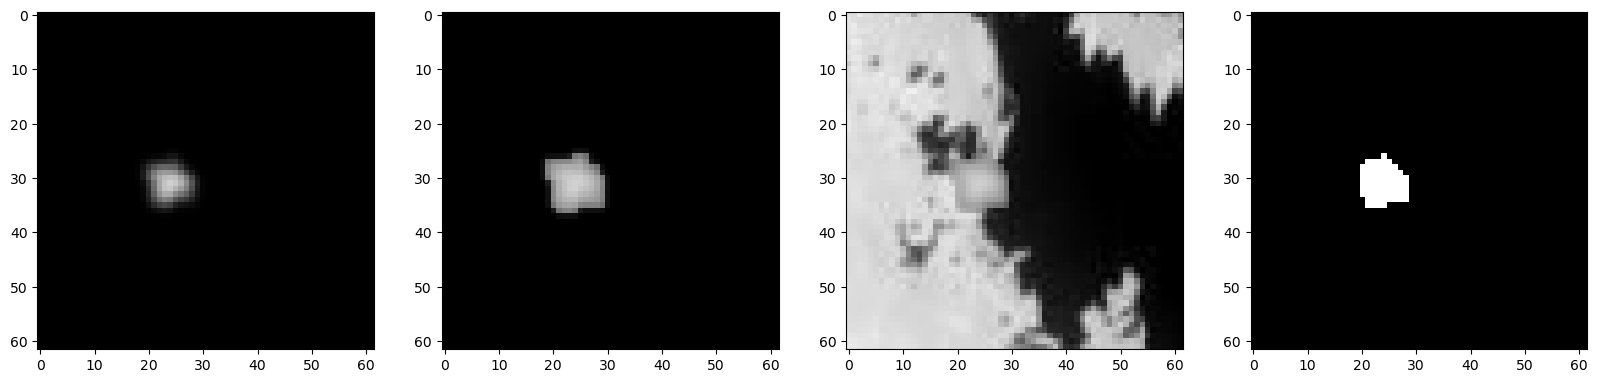

tensor(0.1780)


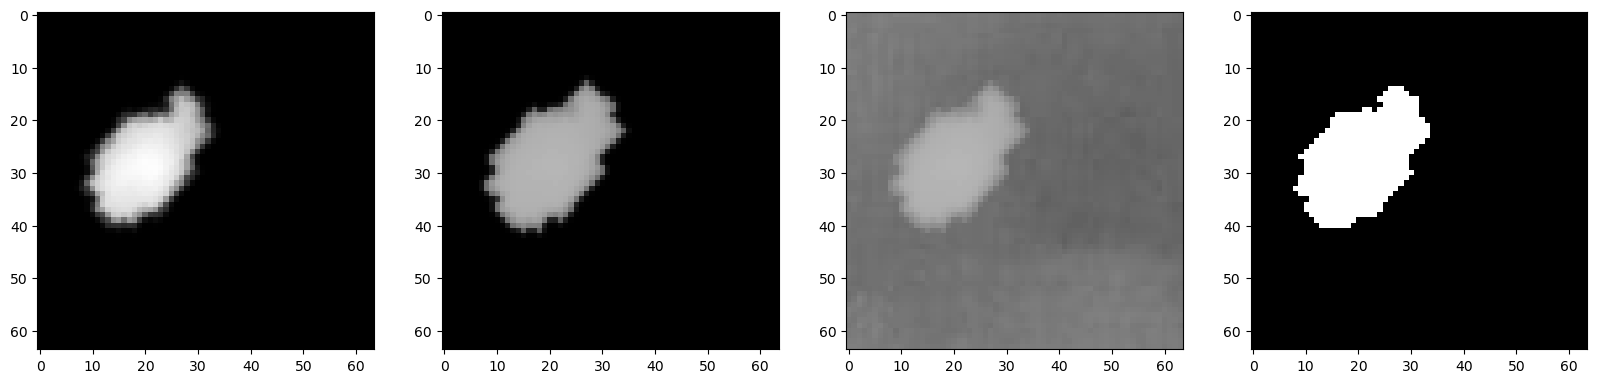

tensor(0.4647)


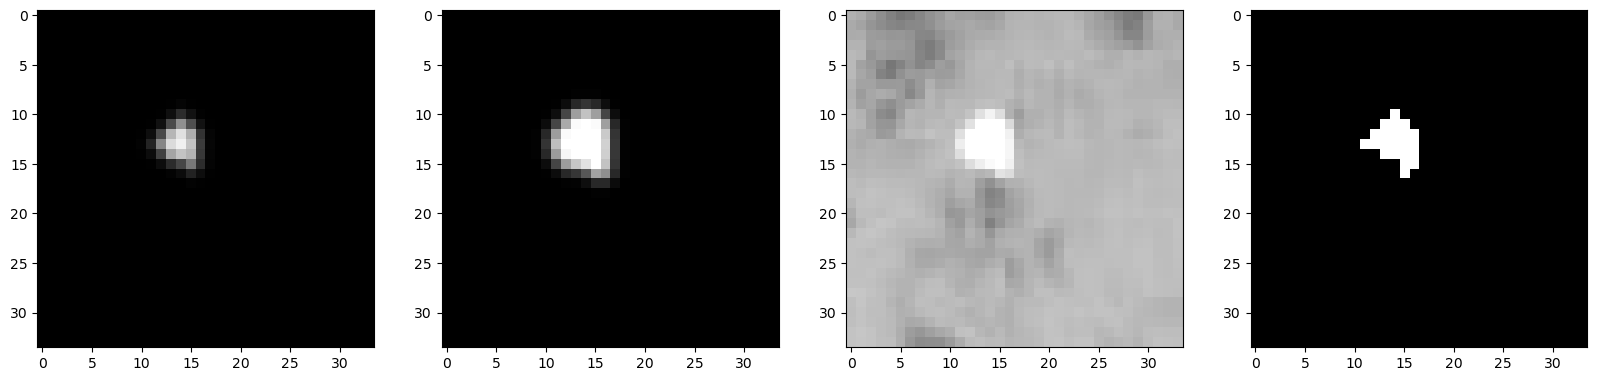

tensor(0.1368)


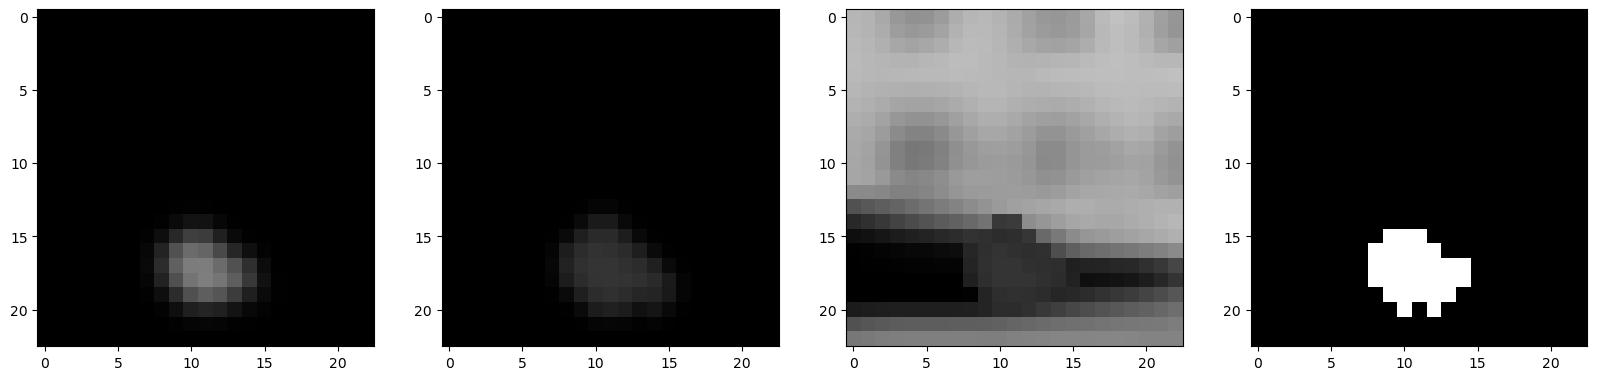

KeyboardInterrupt: Interrupted by user

In [3]:
for i, (img, mask) in enumerate(train_data_loader):
    # plt.figure(figsize=(12, 6))
    # plt.subplot(121), plt.imshow(img[0,0], cmap='gray', vmin=0., vmax=1.)
    # plt.subplot(122), plt.imshow(mask[0,0], cmap='gray', vmin=0., vmax=1.)
    # plt.show()
    # if torch.isnan(img).any():
    #     print('1')
    #     a = input()
    a = input()

In [ ]:
# dense_crf
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral, unary_from_labels, create_pairwise_gaussian

def dense_crf(probs, img=None, n_classes=21, n_iters=1, scale_factor=1):
	#probs = np.transpose(probs,(1,2,0)).copy(order='C')
	c,h,w = probs.shape

	# 我们假设这是一个二分类任务，所以需要扩展到两个类别（包括背景）
	# logits_expanded = np.concatenate([np.zeros_like(probs), probs], axis=0)

	# # 将 logits 转换为 softmax 概率分布
	normal_probs = (probs-np.min(probs))/(np.max(probs) - np.min(probs))
	normal_probs = np.concatenate([normal_probs, 1-normal_probs], axis=0)
	
	unary = unary_from_softmax(normal_probs)
	unary = np.ascontiguousarray(unary)
	img = np.ascontiguousarray(img)

	d = dcrf.DenseCRF2D(w, h, n_classes) # Define DenseCRF model.

	d.setUnaryEnergy(unary)
	# d.addPairwiseGaussian(sxy=3/scale_factor, compat=3)
	feats = create_pairwise_gaussian(sdims=(3, 3), shape=img.shape[:2])
	d.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
	# d.addPairwiseBilateral(sxy=80/scale_factor, srgb=13, rgbim=np.copy(img), compat=10)
	# d.addPairwiseBilateral(sxy=32/scale_factor, srgb=13, rgbim=np.copy(img), compat=10)
	feats = create_pairwise_bilateral(sdims=(80, 80), schan=(13,), img=img, chdim=-1)  # 注意这里的 schan 和 chdim 参数
	d.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
	Q = d.inference(n_iters)

	preds = np.array(Q, dtype=np.float32).reshape((n_classes, h, w))
	# preds = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
	#return np.expand_dims(preds, 0)
	return preds

def pro_crf(p, img, itr):
	# p = np.concatenate([p, 1-p], axis=0)
	crf_pro = dense_crf(p, img.astype(np.uint8), n_classes=2, n_iters=itr)
	return crf_pro


In [3]:
def sigmoid_transformation(x, alpha=10):
    """
    对输入值x应用调整后的Sigmoid函数。
    
    参数:
    x -- 输入数组或标量，取值范围为[0, 1]
    alpha -- 控制曲线陡峭程度的参数，默认值为10
    
    返回:
    y -- 调整后的输出数组或标量，取值范围仍为[0, 1]
    """
    return 1 / (1 + torch.exp(-alpha * (2*x - 1)))

# # 示例用法
# input_values = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# output_values = sigmoid_transformation(input_values)
# print("Sigmoid Transformation:", output_values)

In [25]:
def img_gradient(image_batch):
    op_90 = torch.tensor([[[[-0.25, 0., 0.25],
                            [-2., 0., 2.],
                            [-0.25, 0., 0.25]]]], dtype=image_batch.dtype, device=image_batch.device)
    op_0 = torch.tensor([[[[0.25, 2., 0.25],
                            [ 0., 0., 0.],
                            [-0.25,-2.,-0.25]]]], dtype=image_batch.dtype, device=image_batch.device)
    op_45 = torch.tensor([[[[ 0., 0.177, 1.41],
                            [-0.177, 0., 0.177],
                            [-1.41,-0.177, 0.]]]], dtype=image_batch.dtype, device=image_batch.device)
    op_15 = op_0 * 2/3 + op_45 * 1/3
    op_30 = op_0 * 1/3 + op_45 * 2/3
    op_60 = op_45 * 2/3 + op_90 * 1/3
    op_75 = op_45 * 1/3 + op_90 * 2/3
    op_105 = torch.flip(op_75, dims=[2])
    op_120 = torch.flip(op_60, dims=[2])
    op_135 = torch.flip(op_45, dims=[2])
    op_150 = torch.flip(op_30, dims=[2])
    op_165 = torch.flip(op_15, dims=[2])
    op_180 = torch.flip(op_0, dims=[2])
    op_195 = torch.flip(op_15, dims=[2,3])
    op_210 = torch.flip(op_30, dims=[2,3])
    op_225 = torch.flip(op_45, dims=[2,3])
    op_240 = torch.flip(op_60, dims=[2,3])
    op_255 = torch.flip(op_75, dims=[2,3])
    op_270 = torch.flip(op_90, dims=[3])
    op_285 = torch.flip(op_75, dims=[3])
    op_300 = torch.flip(op_60, dims=[3])
    op_315 = torch.flip(op_45, dims=[3])
    op_330 = torch.flip(op_30, dims=[3])
    op_345 = torch.flip(op_15, dims=[3])

    sobel = torch.concatenate((op_0, op_15, op_30, op_45, op_60, op_75, op_90, op_105, op_120, op_135, op_150, op_165, op_180, op_195, op_210, op_225, op_240, op_255, op_270, op_285, op_300, op_315, op_330, op_345), dim=0)

    grad = F.conv2d(image_batch, sobel, padding=1)  # (B, 24, S, S)
    zeros_tensor = torch.zeros_like(grad)
    grad = torch.where(grad>0, grad, zeros_tensor)

    grad[:,:,:1]=0
    grad[:,:,-1:]=0
    grad[:,:,:,:1]=0
    grad[:,:,:,-1:]=0

    return grad

def img_gradient2(image_batch):
    op_90 = torch.tensor([[[[-0.25, 0.25],
                            [-1., 1.]]]], dtype=image_batch.dtype, device=image_batch.device)
    op_0 = torch.tensor([[[[0.25, 1.],
                           [-0.25,-1.]]]], dtype=image_batch.dtype, device=image_batch.device)
    op_45 = torch.tensor([[[[0., 0.884],
                            [-0.884, 0.]]]], dtype=image_batch.dtype, device=image_batch.device)
    op_15 = op_0 * 2/3 + op_45 * 1/3
    op_30 = op_0 * 1/3 + op_45 * 2/3
    op_60 = op_45 * 2/3 + op_90 * 1/3
    op_75 = op_45 * 1/3 + op_90 * 2/3
    op_105 = torch.flip(op_75, dims=[2])
    op_120 = torch.flip(op_60, dims=[2])
    op_135 = torch.flip(op_45, dims=[2])
    op_150 = torch.flip(op_30, dims=[2])
    op_165 = torch.flip(op_15, dims=[2])
    op_180 = torch.flip(op_0, dims=[2])
    op_195 = torch.flip(op_15, dims=[2,3])
    op_210 = torch.flip(op_30, dims=[2,3])
    op_225 = torch.flip(op_45, dims=[2,3])
    op_240 = torch.flip(op_60, dims=[2,3])
    op_255 = torch.flip(op_75, dims=[2,3])
    op_270 = torch.flip(op_90, dims=[3])
    op_285 = torch.flip(op_75, dims=[3])
    op_300 = torch.flip(op_60, dims=[3])
    op_315 = torch.flip(op_45, dims=[3])
    op_330 = torch.flip(op_30, dims=[3])
    op_345 = torch.flip(op_15, dims=[3])

    sobel = torch.concatenate((op_0, op_15, op_30, op_45, op_60, op_75, op_90, op_105, op_120, op_135, op_150, op_165, op_180, op_195, op_210, op_225, op_240, op_255, op_270, op_285, op_300, op_315, op_330, op_345), dim=0)

    B, _, H, W = image_batch.shape
    grad = F.conv2d(image_batch, sobel, padding=1)  # (B, 24, H+1, W+1)
    grad = grad[:,:,:H,:W]
    grad[:,:,:1]=0
    grad[:,:,:,:1]=0
    zeros_tensor = torch.zeros_like(grad)
    grad = torch.where(grad>0, grad, zeros_tensor)

    # 修正梯度对应像素的位置
    grad = F.pad(grad, (1,1,1,1), mode='constant', value=0) # (B, 24, S+2, S+2)
    grad[:,12:,:, 1:W+1] = grad[:,12:,:, 2:W+2]
    grad[:,:7, 1:H+1,:] = grad[:,:7, 2:H+2,:]
    grad[:,19:, 1:H+1,:] = grad[:,19:, 2:H+2,:]
    grad = grad[:,:,1:H+1,1:W+1]

    return grad

def grad_2nd(gradient):
    op_90 = torch.tensor([[[[-0.25, 0.25],
                            [-1., 1.]]]], dtype=gradient.dtype, device=gradient.device)
    op_0 = torch.tensor([[[[0.25, 1.],
                           [-0.25,-1.]]]], dtype=gradient.dtype, device=gradient.device)
    op_45 = torch.tensor([[[[0., 0.884],
                            [-0.884, 0.]]]], dtype=gradient.dtype, device=gradient.device)
    op_15 = op_0 * 2/3 + op_45 * 1/3
    op_30 = op_0 * 1/3 + op_45 * 2/3
    op_60 = op_45 * 2/3 + op_90 * 1/3
    op_75 = op_45 * 1/3 + op_90 * 2/3
    op_105 = torch.flip(op_75, dims=[2])
    op_120 = torch.flip(op_60, dims=[2])
    op_135 = torch.flip(op_45, dims=[2])
    op_150 = torch.flip(op_30, dims=[2])
    op_165 = torch.flip(op_15, dims=[2])
    op_180 = torch.flip(op_0, dims=[2])
    op_195 = torch.flip(op_15, dims=[2,3])
    op_210 = torch.flip(op_30, dims=[2,3])
    op_225 = torch.flip(op_45, dims=[2,3])
    op_240 = torch.flip(op_60, dims=[2,3])
    op_255 = torch.flip(op_75, dims=[2,3])
    op_270 = torch.flip(op_90, dims=[3])
    op_285 = torch.flip(op_75, dims=[3])
    op_300 = torch.flip(op_60, dims=[3])
    op_315 = torch.flip(op_45, dims=[3])
    op_330 = torch.flip(op_30, dims=[3])
    op_345 = torch.flip(op_15, dims=[3])

    grad_0 = F.conv2d(gradient[:,:1], op_0, padding=1)
    grad_15 = F.conv2d(gradient[:,1:2], op_15, padding=1)
    grad_30 = F.conv2d(gradient[:,2:3], op_30, padding=1)
    grad_45 = F.conv2d(gradient[:,3:4], op_45, padding=1)
    grad_60 = F.conv2d(gradient[:,4:5], op_60, padding=1)
    grad_75 = F.conv2d(gradient[:,5:6], op_75, padding=1)
    grad_90 = F.conv2d(gradient[:,6:7], op_90, padding=1)
    grad_105 = F.conv2d(gradient[:,7:8], op_105, padding=1)
    grad_120 = F.conv2d(gradient[:,8:9], op_120, padding=1)
    grad_135 = F.conv2d(gradient[:,9:10], op_135, padding=1)
    grad_150 = F.conv2d(gradient[:,10:11], op_150, padding=1)
    grad_165 = F.conv2d(gradient[:,11:12], op_165, padding=1)
    grad_180 = F.conv2d(gradient[:,12:13], op_180, padding=1)
    grad_195 = F.conv2d(gradient[:,13:14], op_195, padding=1)
    grad_210 = F.conv2d(gradient[:,14:15], op_210, padding=1)
    grad_225 = F.conv2d(gradient[:,15:16], op_225, padding=1)
    grad_240 = F.conv2d(gradient[:,16:17], op_240, padding=1)
    grad_255 = F.conv2d(gradient[:,17:18], op_255, padding=1)
    grad_270 = F.conv2d(gradient[:,18:19], op_270, padding=1)
    grad_285 = F.conv2d(gradient[:,19:20], op_285, padding=1)
    grad_300 = F.conv2d(gradient[:,20:21], op_300, padding=1)
    grad_315 = F.conv2d(gradient[:,21:22], op_315, padding=1)
    grad_330 = F.conv2d(gradient[:,22:23], op_330, padding=1)
    grad_345 = F.conv2d(gradient[:,23:24], op_345, padding=1)

    gradient_ = torch.concatenate((grad_0, grad_15, grad_30, grad_45, grad_60, grad_75, grad_90, grad_105, grad_120, grad_135, grad_150, grad_165, grad_180, grad_195, grad_210, grad_225, grad_240, grad_255, grad_270, grad_285, grad_300, grad_315, grad_330, grad_345), dim=1)

    B, _, H, W = gradient.shape
    gradient_ = gradient_[:,:,:H,:W]
    gradient_[:,:,:1]=0
    gradient_[:,:,:,:1]=0
    zeros_tensor = torch.zeros_like(gradient_)
    gradient_ = torch.where(gradient_>0, gradient_, zeros_tensor)   # ?

    # 修正梯度对应像素的位置
    gradient_ = F.pad(gradient_, (1,1,1,1), mode='constant', value=0) # (B, 24, S+2, S+2)
    gradient_[:,12:,:, 1:W+1] = gradient_[:,12:,:, 2:W+2]
    gradient_[:,:7, 1:H+1,:] = gradient_[:,:7, 2:H+2,:]
    gradient_[:,19:, 1:H+1,:] = gradient_[:,19:, 2:H+2,:]
    gradient_ = gradient_[:,:,1:H+1,1:W+1]

    return gradient_

def normalize_channels(tensor):
    """
    对形状为 (B, C, S, S) 的张量中的每个通道进行归一化。
    
    参数:
    tensor -- 输入张量
    
    返回:
    normalized_tensor -- 归一化后的张量
    """
    # 计算每个通道的均值和标准差，忽略批次和空间维度
    mean = tensor.mean(dim=[0, 2, 3], keepdim=True)
    std = tensor.std(dim=[0, 2, 3], keepdim=True)
    
    # 避免除以零的情况
    std_non_zero = torch.where(std == 0, torch.tensor(1.), std)

    # 归一化每个通道
    normalized_tensor = (tensor - mean) / std_non_zero
    
    return normalized_tensor

def gauss_filter(tensor):
    """
    对形状为 (B, C, S, S) 的张量进行高斯滤波。
    
    参数:
    tensor -- 输入张量
    
    返回:
    filtered_tensor -- 滤波后的张量
    """
    _, _, H, W = tensor.shape
    # 创建高斯核
    op_90 = torch.tensor([[[[-0.25, 0.25],
                            [-1., 1.]]]], dtype=tensor.dtype, device=tensor.device)
    op_0 = torch.tensor([[[[0.25, 1.],
                           [-0.25,-1.]]]], dtype=tensor.dtype, device=tensor.device)
    op_45 = torch.tensor([[[[0., 0.884],
                            [-0.884, 0.]]]], dtype=tensor.dtype, device=tensor.device)
    op_15 = op_0 * 2/3 + op_45 * 1/3
    op_30 = op_0 * 1/3 + op_45 * 2/3
    op_60 = op_45 * 2/3 + op_90 * 1/3
    op_75 = op_45 * 1/3 + op_90 * 2/3
    op_105 = torch.flip(op_75, dims=[2])
    op_120 = torch.flip(op_60, dims=[2])
    op_135 = torch.flip(op_45, dims=[2])
    op_150 = torch.flip(op_30, dims=[2])
    op_165 = torch.flip(op_15, dims=[2])
    op_180 = torch.flip(op_0, dims=[2])
    op_195 = torch.flip(op_15, dims=[2,3])
    op_210 = torch.flip(op_30, dims=[2,3])
    op_225 = torch.flip(op_45, dims=[2,3])
    op_240 = torch.flip(op_60, dims=[2,3])
    op_255 = torch.flip(op_75, dims=[2,3])
    op_270 = torch.flip(op_90, dims=[3])
    op_285 = torch.flip(op_75, dims=[3])
    op_300 = torch.flip(op_60, dims=[3])
    op_315 = torch.flip(op_45, dims=[3])
    op_330 = torch.flip(op_30, dims=[3])
    op_345 = torch.flip(op_15, dims=[3])

    grad_0 = F.conv2d(tensor[:,:1], op_0, padding=1)[:,:,1:,1:] * F.conv2d(tensor[:,:1], op_180, padding=1)[:,:,:H,1:]
    
    grad_15 = F.conv2d(tensor[:,1:2], op_15, padding=1)[:,:,1:,:W] * F.conv2d(tensor[:,1:2], op_195, padding=1)[:,:,:H,1:]
    grad_30 = F.conv2d(tensor[:,2:3], op_30, padding=1)[:,:,1:,:W] * F.conv2d(tensor[:,2:3], op_210, padding=1)[:,:,:H,1:]
    grad_45 = F.conv2d(tensor[:,3:4], op_45, padding=1)[:,:,1:,:W] * F.conv2d(tensor[:,3:4], op_225, padding=1)[:,:,:H,1:]
    
    grad_60 = F.conv2d(tensor[:,4:5], op_60, padding=1)[:,:,1:,:W] * F.conv2d(tensor[:,4:5], op_240, padding=1)[:,:,:H,1:]
    grad_75 = F.conv2d(tensor[:,5:6], op_75, padding=1)[:,:,1:,:W] * F.conv2d(tensor[:,5:6], op_255, padding=1)[:,:,:H,1:]
    grad_90 = F.conv2d(tensor[:,6:7], op_90, padding=1)[:,:,1:,:W] * F.conv2d(tensor[:,6:7], op_270, padding=1)[:,:,1:,1:]
    
    grad_105 = F.conv2d(tensor[:,7:8], op_105, padding=1)[:,:,:H,:W] * F.conv2d(tensor[:,7:8], op_285, padding=1)[:,:,1:,1:]
    grad_120 = F.conv2d(tensor[:,8:9], op_120, padding=1)[:,:,:H,:W] * F.conv2d(tensor[:,8:9], op_300, padding=1)[:,:,1:,1:]
    grad_135 = F.conv2d(tensor[:,9:10], op_135, padding=1)[:,:,:H,:W] * F.conv2d(tensor[:,9:10], op_315, padding=1)[:,:,1:,1:]
    grad_150 = F.conv2d(tensor[:,10:11], op_150, padding=1)[:,:,:H,:W] * F.conv2d(tensor[:,10:11], op_330, padding=1)[:,:,1:,1:]
    grad_165 = F.conv2d(tensor[:,11:12], op_165, padding=1)[:,:,:H,:W] * F.conv2d(tensor[:,11:12], op_345, padding=1)[:,:,1:,1:]
    grad_180 = F.conv2d(tensor[:,12:13], op_180, padding=1)[:,:,:H,:W] * F.conv2d(tensor[:,12:13], op_0, padding=1)[:,:,1:,:W]
    
    grad_195 = F.conv2d(tensor[:,13:14], op_195, padding=1)[:,:,:H,1:] * F.conv2d(tensor[:,13:14], op_15, padding=1)[:,:,1:,:W]
    grad_210 = F.conv2d(tensor[:,14:15], op_210, padding=1)[:,:,:H,1:] * F.conv2d(tensor[:,14:15], op_30, padding=1)[:,:,1:,:W]
    grad_225 = F.conv2d(tensor[:,15:16], op_225, padding=1)[:,:,:H,1:] * F.conv2d(tensor[:,15:16], op_45, padding=1)[:,:,1:,:W]
    grad_240 = F.conv2d(tensor[:,16:17], op_240, padding=1)[:,:,:H,1:] * F.conv2d(tensor[:,16:17], op_60, padding=1)[:,:,1:,:W]
    grad_255 = F.conv2d(tensor[:,17:18], op_255, padding=1)[:,:,:H,1:] * F.conv2d(tensor[:,17:18], op_75, padding=1)[:,:,1:,:W]
    grad_270 = F.conv2d(tensor[:,18:19], op_270, padding=1)[:,:,:H,1:] * F.conv2d(tensor[:,18:19], op_90, padding=1)[:,:,:H,:W]

    grad_285 = F.conv2d(tensor[:,19:20], op_285, padding=1)[:,:,1:,1:] * F.conv2d(tensor[:,19:20], op_105, padding=1)[:,:,:H,:W]
    grad_300 = F.conv2d(tensor[:,20:21], op_300, padding=1)[:,:,1:,1:] * F.conv2d(tensor[:,20:21], op_120, padding=1)[:,:,:H,:W]
    grad_315 = F.conv2d(tensor[:,21:22], op_315, padding=1)[:,:,1:,1:] * F.conv2d(tensor[:,21:22], op_135, padding=1)[:,:,:H,:W]
    # grad_315_1 = F.conv2d(tensor[:,21:22], op_315, padding=1)
    # grad_315_1 = torch.where(grad_315_1 > 0, grad_315_1, torch.zeros_like(grad_315_1))
    # grad_315_2 =  F.conv2d(tensor[:,21:22], op_45, padding=1)
    # grad_315_2 = torch.where(grad_315_2 > 0, grad_315_2, torch.zeros_like(grad_315_2))
    grad_330 = F.conv2d(tensor[:,22:23], op_330, padding=1)[:,:,1:,1:] * F.conv2d(tensor[:,22:23], op_150, padding=1)[:,:,:H,:W]
    grad_345 = F.conv2d(tensor[:,23:24], op_345, padding=1)[:,:,1:,1:] * F.conv2d(tensor[:,23:24], op_165, padding=1)[:,:,:H,:W]

    filtered_tensor = torch.concatenate((grad_0, grad_15, grad_30, grad_45, grad_60, grad_75, grad_90, grad_105, grad_120, grad_135, grad_150, grad_165, grad_180, grad_195, grad_210, grad_225, grad_240, grad_255, grad_270, grad_285, grad_300, grad_315, grad_330, grad_345), dim=1)

    filtered_tensor[:,:,:1]=0
    filtered_tensor[:,:,:,:1]=0
    filtered_tensor[:,:,H-1:]=0
    filtered_tensor[:,:,:,W-1:]=0
    zeros_tensor = torch.zeros_like(filtered_tensor)
    ones_tensor = torch.ones_like(filtered_tensor)
    filtered_tensor = torch.where(filtered_tensor>0., ones_tensor, zeros_tensor)   # ?

    # # 显示结果
    # plt.figure(figsize=(24, 6))
    # plt.subplot(141), plt.imshow(tensor[0,21], cmap='gray')
    # plt.subplot(142), plt.imshow(grad_315_1[0,0], cmap='gray')
    # plt.subplot(143), plt.imshow(grad_315_2[0,0], cmap='gray')
    # plt.subplot(144), plt.imshow(filtered_tensor[0,21], cmap='gray')
    # plt.show()
 
    return filtered_tensor

def prepare4gradient_expand(gradient, zoom_rate):
    _, C, _, _ = gradient.shape
    gradient_ = gradient.clone()
    for i in range(C):
        t_idx = (i + C // 2) % C
        gradient_[:, i] = gradient[:, t_idx] * (-zoom_rate)
    
    return gradient_

def gradient_expand(gradient, rate, minus_gradient):

    # op_0 = torch.tensor([[[[0.05, 0.9, 0.05],
    #                        [0.0, 0.0, 0.0],
    #                        [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    # op_45 = torch.tensor([[[[0.0, 0.07, 0.86],
    #                         [0.0, 0.0, 0.07],
    #                         [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    # op_90 = torch.tensor([[[[0.0, 0.0, 0.05],
    #                         [0.0, 0.0, 0.9],
    #                         [0.0, 0.0, 0.05]]]], dtype=gradient.dtype, device=gradient.device) * rate
    # op_0 = torch.tensor([[[[0.2, 0.6, 0.2],
    #                        [0.0, 0.0, 0.0],
    #                        [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    # op_45 = torch.tensor([[[[0.0, 0.282, 0.436],
    #                         [0.0, 0.0, 0.282],
    #                         [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    # op_90 = torch.tensor([[[[0.0, 0.0, 0.2],
    #                         [0.0, 0.0, 0.6],
    #                         [0.0, 0.0, 0.2]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op_0 = torch.tensor([[[[0.0, 1., 0.0],
                           [0.0, 0.0, 0.0],
                           [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op_45 = torch.tensor([[[[0.0, 0.0, 1.],
                            [0.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op_90 = torch.tensor([[[[0.0, 0.0, 0.0],
                            [0.0, 0.0, 1.],
                            [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate 
    op_15 = op_0 * 2/3 + op_45 * 1/3
    op_30 = op_0 * 1/3 + op_45 * 2/3
    op_60 = op_45 * 2/3 + op_90 * 1/3
    op_75 = op_45 * 1/3 + op_90 * 2/3

    grad_0 = F.conv2d(gradient[:,:1], torch.flip(op_0, dims=[2]), padding=1)
    grad_15 = F.conv2d(gradient[:,1:2], torch.flip(op_15, dims=[2, 3]), padding=1)
    grad_30 = F.conv2d(gradient[:,2:3], torch.flip(op_30, dims=[2, 3]), padding=1)
    grad_45 = F.conv2d(gradient[:,3:4], torch.flip(op_45, dims=[2, 3]), padding=1)
    grad_60 = F.conv2d(gradient[:,4:5] , torch.flip(op_60, dims=[2, 3]), padding=1)
    grad_75 = F.conv2d(gradient[:,5:6], torch.flip(op_75, dims=[2, 3]), padding=1)
    grad_90 = F.conv2d(gradient[:,6:7], torch.flip(op_90, dims=[3]), padding=1)
    grad_105 = F.conv2d(gradient[:,7:8], torch.flip(op_75, dims=[3]), padding=1)
    grad_120 = F.conv2d(gradient[:,8:9], torch.flip(op_60, dims=[3]), padding=1)
    grad_135 = F.conv2d(gradient[:,9:10], torch.flip(op_45, dims=[3]), padding=1)
    grad_150 = F.conv2d(gradient[:,10:11], torch.flip(op_30, dims=[3]), padding=1)
    grad_165 = F.conv2d(gradient[:,11:12], torch.flip(op_15, dims=[3]), padding=1)
    grad_180 = F.conv2d(gradient[:,12:13], op_0, padding=1)
    grad_195 = F.conv2d(gradient[:,13:14], op_15, padding=1)
    grad_210 = F.conv2d(gradient[:,14:15], op_30, padding=1)
    grad_225 = F.conv2d(gradient[:,15:16], op_45, padding=1)
    grad_240 = F.conv2d(gradient[:,16:17], op_60, padding=1)
    grad_255 = F.conv2d(gradient[:,17:18], op_75, padding=1)
    grad_270 = F.conv2d(gradient[:,18:19], op_90, padding=1)
    grad_285 = F.conv2d(gradient[:,19:20], torch.flip(op_75, dims=[2]), padding=1)
    grad_300 = F.conv2d(gradient[:,20:21], torch.flip(op_60, dims=[2]), padding=1)
    grad_315 = F.conv2d(gradient[:,21:22], torch.flip(op_45, dims=[2]), padding=1)
    grad_330 = F.conv2d(gradient[:,22:23], torch.flip(op_30, dims=[2]), padding=1)
    grad_345 = F.conv2d(gradient[:,23:24], torch.flip(op_15, dims=[2]), padding=1)

    # grad_top = F.conv2d(gradient[:,:1], torch.flip(op2, dims=[2]), padding=1)
    # grad_bot = F.conv2d(gradient[:,1:2], op2, padding=1)
    # grad_right = F.conv2d(gradient[:,2:3], op3, padding=1)
    # grad_left = F.conv2d(gradient[:,3:4], torch.flip(op3, dims=[3]), padding=1)
    # grad_topleft = F.conv2d(gradient[:,4:5], torch.flip(op1, dims=[2,3]), padding=1)
    # grad_botright = F.conv2d(gradient[:,5:6], op1, padding=1)
    # grad_topright = F.conv2d(gradient[:,6:7], torch.flip(op1, dims=[2]), padding=1)
    # grad_botleft = F.conv2d(gradient[:,7:8], torch.flip(op1, dims=[3]),padding=1)
    # gradient_ = torch.concatenate((grad_top, grad_bot, grad_right, grad_left, grad_topleft, grad_botright, grad_topright, grad_botleft), dim=1)
    # gradient_ = torch.where(gradient*rate > gradient_, gradient, gradient_)
    gradient_ = torch.concatenate((grad_0, grad_15, grad_30, grad_45, grad_60, grad_75, grad_90, grad_105, grad_120, grad_135, grad_150, grad_165, grad_180, grad_195, grad_210, grad_225, grad_240, grad_255, grad_270, grad_285, grad_300, grad_315, grad_330, grad_345), dim=1)
    gradient_ = gradient_ + minus_gradient
    # gradient_ = gradient_ + gradient

    gradient_ = torch.where(gradient > gradient_, gradient, gradient_)

    return gradient_

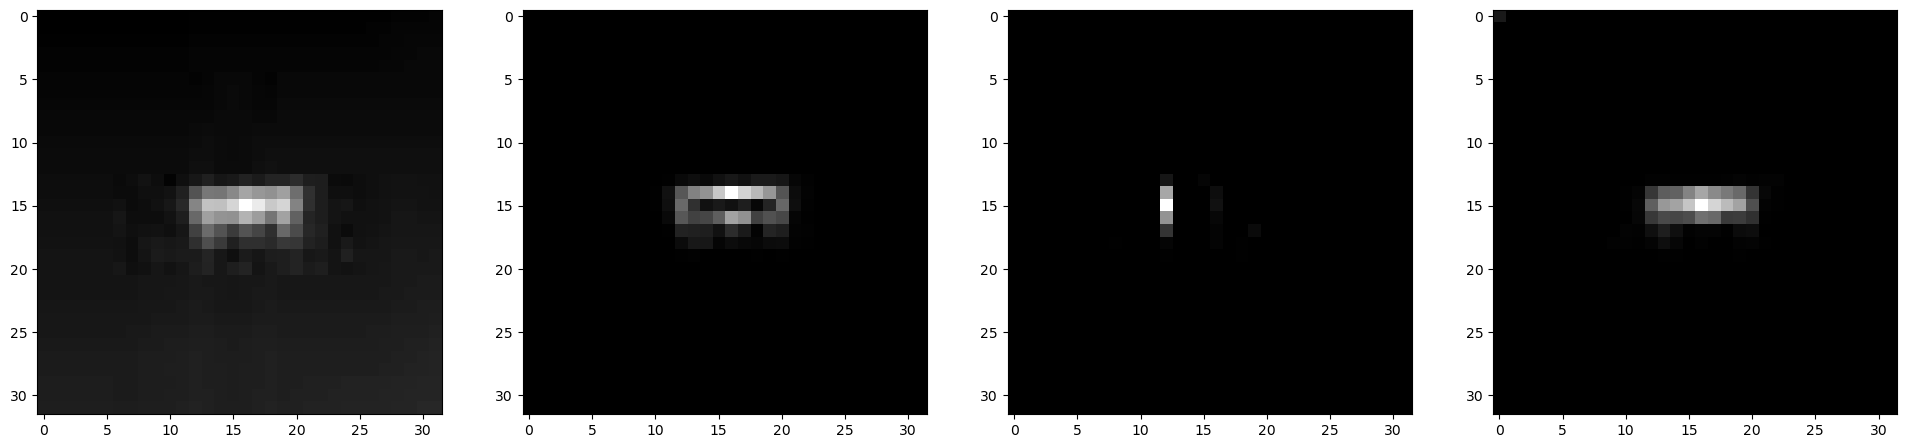

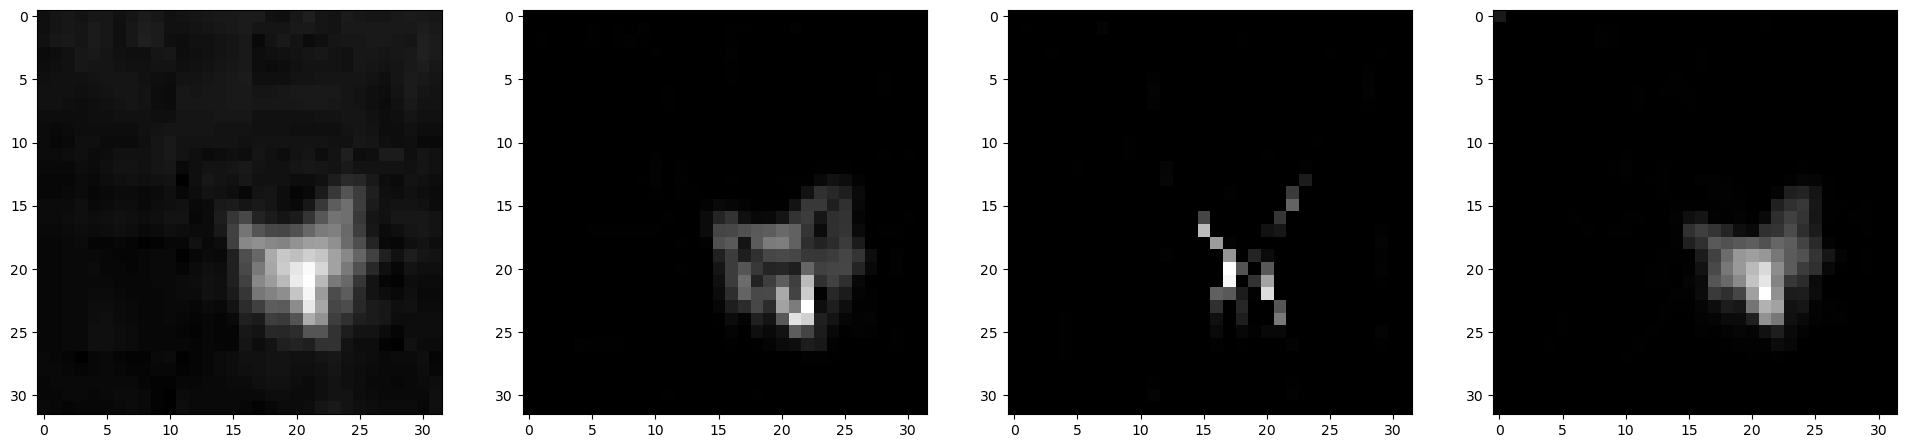

KeyboardInterrupt: Interrupted by user

In [ ]:
regions = []
img_idx = -1
pre_batch_idx = -1
pre_j_idx = -1
for j, (data, label) in enumerate(train_data_loader):
    B, _, S, _ = data.shape
    indices = torch.where(label > 0.)
    region_size = 32
    half_region_size = region_size // 2
    for b, _, s1, s2 in zip(*indices):
        # # 计算索引
        # if b != pre_batch_idx or j != pre_j_idx:
        #     pre_batch_idx = b
        #     pre_j_idx = j
        #     img_idx += 1

        # # 计算区域的边界
        # start_s1 = max(0, s1 - half_region_size)
        # end_s1 = min(S, s1 + half_region_size)
        # start_s2 = max(0, s2 - half_region_size)
        # end_s2 = min(S, s2 + half_region_size)
        
        # # 提取区域
        # region = data[b, 0, start_s1:end_s1, start_s2:end_s2]
        region = data[b, 0]
        original_region = region.clone()
        # region = (region-torch.min(region))/(torch.max(region) - torch.min(region))

        img_gradient_ = img_gradient(region.unsqueeze(0).unsqueeze(0))  # 3*3 sobel oprater
        img_gradient_2 = img_gradient2(region.unsqueeze(0).unsqueeze(0))    # 2*2 sobel oprater
        img_gradient_ = img_gradient_ * img_gradient_2
        img_gradient_3 = gauss_filter(img_gradient_) * img_gradient_    # only keep highest gradient in same direction

        minus_gradient = prepare4gradient_expand(img_gradient_3, 1e20)
        expanded_grad = img_gradient_3
        for i in range(region_size):
            expanded_grad = gradient_expand(expanded_grad, 1.0, minus_gradient)
    
        # p = np.array(torch.sum(expanded_grad, dim=1))
        # p_img = np.array(original_region) * 255
        # result = pro_crf(p, p_img, 20)
        
        target_info = {"original_region": original_region, "region": torch.sum(expanded_grad[0], dim=0), "img_idx": img_idx, 'height_start_idx': start_s1, 'height_end_idx':end_s1, 'width_start_idx': start_s2, 'width_end_idx':end_s2}
        regions.append(target_info)
        # 查看过滤
        target = torch.sum(expanded_grad[0], dim=0)
        target = (target - target.min())/(target.max() - target.min())
        target[0,0] = 0.1
        # mean_val = (torch.max(target) + torch.mean(target))/2
        # target = torch.where(target > mean_val, target, torch.zeros_like(target))
        # 显示结果
        plt.figure(figsize=(24, 6))
        plt.subplot(141), plt.imshow(original_region, cmap='gray')
        plt.subplot(142), plt.imshow(torch.sum(img_gradient_[0], dim=0), cmap='gray')
        plt.subplot(143), plt.imshow(img_gradient_3[0,6], cmap='gray')
        plt.subplot(144), plt.imshow(target, cmap='gray') 
        plt.show()

        # if region.shape != (region_size, region_size):
        #     region = torch.nn.functional.pad(region, (0, region_size - region.shape[1], 0, region_size - region.shape[0]), mode='reflect')
        
        a = input()
for i in range(len(regions)):
    image_data = np.array(regions[i]["region"])
    original_image_data = np.array(regions[i]["original_region"])
    normalized_original_image_data = (original_image_data * 255).astype(np.uint8) 
    # 归一化到 0-255 范围内
    min_val = image_data.min()
    max_val = image_data.max()
    normalized_image_data = ((image_data - min_val) / (max_val - min_val) * 255).astype(np.uint8)

    # 将 NumPy 数组转换为 PIL 图像
    image = Image.fromarray(normalized_image_data, mode='L')  # 'L' 表示灰度模式
    image_ori = Image.fromarray(normalized_original_image_data, mode='L')
    # 保存图像到本地文件
    path = "W:/DataSets/ISTD/IRSTD-1k/trainval/target_GE_result32_3/"
    original_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/target_ori_image32_3/"
    base_name = "{:04d}_{:04d}_{:04d}_{:04d}_{:04d}.png"
    image.save(path + base_name.format(regions[i]["img_idx"], regions[i]["height_start_idx"], regions[i]["height_end_idx"], regions[i]["width_start_idx"], regions[i]["width_end_idx"]))
    image_ori.save(original_path + base_name.format(regions[i]["img_idx"], regions[i]["height_start_idx"], regions[i]["height_end_idx"], regions[i]["width_start_idx"], regions[i]["width_end_idx"]))

In [8]:
def load_image(image_path):
    """加载图像并转换为灰度模式"""
    image = Image.open(image_path).convert('L')
    return np.array(image)

def calculate_histogram(image):
    """计算图像的亮度直方图"""
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    return hist, bins[:-1]

def smooth_histogram(hist, sigma=5, window_size=3):
    """多步平滑直方图"""
    # 使用移动平均滤波器进行初步平滑
    moving_avg_hist = np.convolve(hist, np.ones(window_size)/window_size, mode='same')
    
    # 使用高斯滤波器进行最终平滑
    smoothed_hist = gaussian_filter1d(moving_avg_hist, sigma=sigma)
    
    return smoothed_hist

def find_last_valley(hist):
    """查找直方图中的最后一个低谷"""
    # 这里简单地通过寻找直方图中从后向前的第一个极小值点来确定低谷
    for i in range(len(hist)-2, 0, -1):
        if hist[i] < hist[i-1] and hist[i] < hist[i+1]:
            return i
    return None

def find_first_major_peak_and_valley(hist):
    """查找直方图中的第一个大波峰及其后的第一个大低谷"""
    # 平滑直方图
    smoothed_hist = smooth_histogram(hist)
    
    # 找到波峰
    peaks, _ = find_peaks(smoothed_hist, distance=10, prominence=1)
    
    if len(peaks) == 0:
        # return None, None
        for i in range(len(smoothed_hist)):
            if smoothed_hist[i] <= 1:
                break
        return None, i
    
    
    first_peak = peaks[0]
    
    # 从第一个波峰开始找到第一个大低谷
    valleys, _ = find_peaks(-smoothed_hist[first_peak:], distance=10)
    
    if len(valleys) == 0:
        # return first_peak, None
        pixel_num = 0
        i = 0
        for i in range(len(hist)-2, 0, -1):
            if pixel_num > 256:
                break
            pixel_num += hist[i]
        return first_peak, i
        
        
    first_valley = first_peak + valleys[0]
    
    return first_peak, first_valley

def filter_image(image, threshold):
    """根据阈值过滤图像"""
    filtered_image = image.copy()
    filtered_image[image < threshold] = 0  # 将低于阈值的像素设为黑色
    return filtered_image

path = "W:/DataSets/ISTD/IRSTD-1k/trainval/target_GE_result32_3"
ori_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/target_ori_image32_3"
pixel_pseudo_label_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/pixel_pseudo_label0.3"
img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images"
origin_name = os.listdir(img_path)
img_idx= 0
pseudo_labels = [[],] 
perfect_target = []
for filename in os.listdir(path):
    # 确定图片所属数据集图片的文件名
    target_info = filename.split('_')
    num = int(target_info[0])
    if num != img_idx:
        pseudo_labels.append([])
        img_idx += 1
    # 加载图像
    image_path = path + '/' + filename
    image = load_image(image_path)
    
    # 计算直方图
    hist, bins = calculate_histogram(image)

    # 查找第一个山峰及其后的第一个低谷
    first_peak, first_valley = find_first_major_peak_and_valley(hist)
    # print(f"First peak found at brightness level: {first_peak}")
    # print(f"First valley after the first peak found at brightness level: {first_valley}")
    
    # 根据低谷过滤图像
    if first_valley is not None:
        filtered_image = filter_image(image, first_valley)
    else:
        filtered_image = image  # 如果没有找到低谷，则不进行过滤
    # filtered_image = image
    
    pseudo_labels[-1].append({"filtered_image": filtered_image, 'height_start_idx': int(target_info[1]), 'height_end_idx':int(target_info[2]), 'width_start_idx': int(target_info[3]), 'width_end_idx':int(target_info[4].split('.')[0])})

    # 收集完美的目标
    labels, num_features = ndimage.label(filtered_image > 0.1)
    if num_features == 1:
        ori_pict =load_image(img_path + '/' + origin_name[img_idx])
        accor_part = ori_pict[int(target_info[1]):int(target_info[2]), int(target_info[3]):int(target_info[4].split('.')[0])]
        target = (filtered_image > 22.) * accor_part
        perfect_target.append(target)

    # # 绘制直方图
    # plt.figure(figsize=(20, 5))
    
    # # 原始图像
    # plt.subplot(1, 4, 1)
    # plt.imshow(image, cmap='gray')
    # plt.title('Original Image') 
    # plt.axis('off')
    
    # # 直方图
    # plt.subplot(1, 4, 2)
    # plt.bar(bins, hist, color='blue', alpha=0.7, label='Histogram')
    # smoothed_hist = smooth_histogram(hist)
    # plt.plot(bins, smoothed_hist, color='orange', label='Smoothed Histogram')
    # if first_peak is not None:
    #     plt.axvline(x=first_peak, color='green', linestyle='--', label=f'First Major Peak: {first_peak}')
    # if first_valley is not None:
    #     plt.axvline(x=first_valley, color='red', linestyle='--', label=f'First Major Valley: {first_valley}')
    # plt.legend()
    # plt.title('Brightness Histogram')
    # plt.xlabel('Brightness Level')
    # plt.ylabel('Pixel Count')
    # plt.ylim(0, 50)  # 设置bottom和top为你想要的y轴范围
    
    # # 过滤后的图像
    # plt.subplot(1, 4, 3)
    # plt.imshow(filtered_image, cmap='gray')
    # plt.title('Filtered Image')
    # plt.axis('off')

    # # 展示对齐效果
    # # 加载原图（假设为灰度图）
    # image_path = ori_path + '/' + filename
    # image = np.array(Image.open(image_path).convert('L'))

    # # 加载或生成掩码（假设为二值图，0为背景，255为目标区域）
    # mask = ((filtered_image > 0)*255).astype(np.uint8)

    # # 将灰度图转换为RGB图
    # image_rgb = np.stack([mask, image, image], axis=-1)

    # plt.subplot(1, 4, 4)
    # plt.imshow(image_rgb)
    # plt.title('Overlap')
    # plt.axis('off')
    
    # plt.tight_layout()
    # plt.show()

    # a = input()

pesudo_labels_ = []
for i in range(len(pseudo_labels)):
    pseudo_label = np.zeros((512, 512))
    for j in pseudo_labels[i]:
        # print(j["height_start_idx"], j["height_end_idx"], j["width_start_idx"],j["width_end_idx"], j["filtered_image"].shape)
        pseudo_label[j["height_start_idx"]: j["height_end_idx"], j["width_start_idx"]: j["width_end_idx"]] = j["filtered_image"]
    # plt.imshow(pseudo_label, cmap='gray')
    # plt.title(origin_name[i])
    # plt.show()
    pseudo_label_image = Image.fromarray(pseudo_label.astype(np.uint8), mode='L')  # 'L' 表示灰度模式
    pseudo_label_image.save(pixel_pseudo_label_path + '/' + origin_name[i])

# 保存完美的目标
perfect_target_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/perfect_target"
for i in range(len(perfect_target)):
    perfect_target_image = Image.fromarray(perfect_target[i].astype(np.uint8), mode='L')  # 'L' 表示灰度模式
    perfect_target_image.save(perfect_target_path + '/' + f'{i:04d}.png')


In [8]:
def adaptive_canny_based_on_histogram(image):
    """
    使用基于图像直方图的自适应Canny边缘检测。
    
    参数:
        image (numpy.ndarray): 输入的灰度图像，形状为 (H, W).
        
    返回:
        numpy.ndarray: 经过Canny边缘检测处理后的二值图像，形状为 (H, W).
    """
    # 确保输入的是单通道灰度图像
    if len(image.shape) != 2:
        raise ValueError("输入图像必须是单通道灰度图像")

    # 使用Otsu's方法找到全局阈值
    val, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 设置低阈值和高阈值为Otsu阈值的一定比例
    low_threshold = int(0.5 * val)
    high_threshold = int(val)
    
    # 应用Canny边缘检测
    edges = cv2.Canny(image, low_threshold, high_threshold)

    return edges

edges = []
edges_save_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/canny_edge"
ori_names = os.listdir("W:/DataSets/ISTD/IRSTD-1k/trainval/images")
img_idx=0
for j, (data, label) in enumerate(train_data_loader):
    B, _, S, _ = data.shape
    for i in range(B):
        img = (data[i, 0].numpy() * 255).astype(np.uint8)
        canny_edges = adaptive_canny_based_on_histogram(img)
        cv2.imwrite(edges_save_path + '/' + ori_names[img_idx], canny_edges)
        img_idx += 1


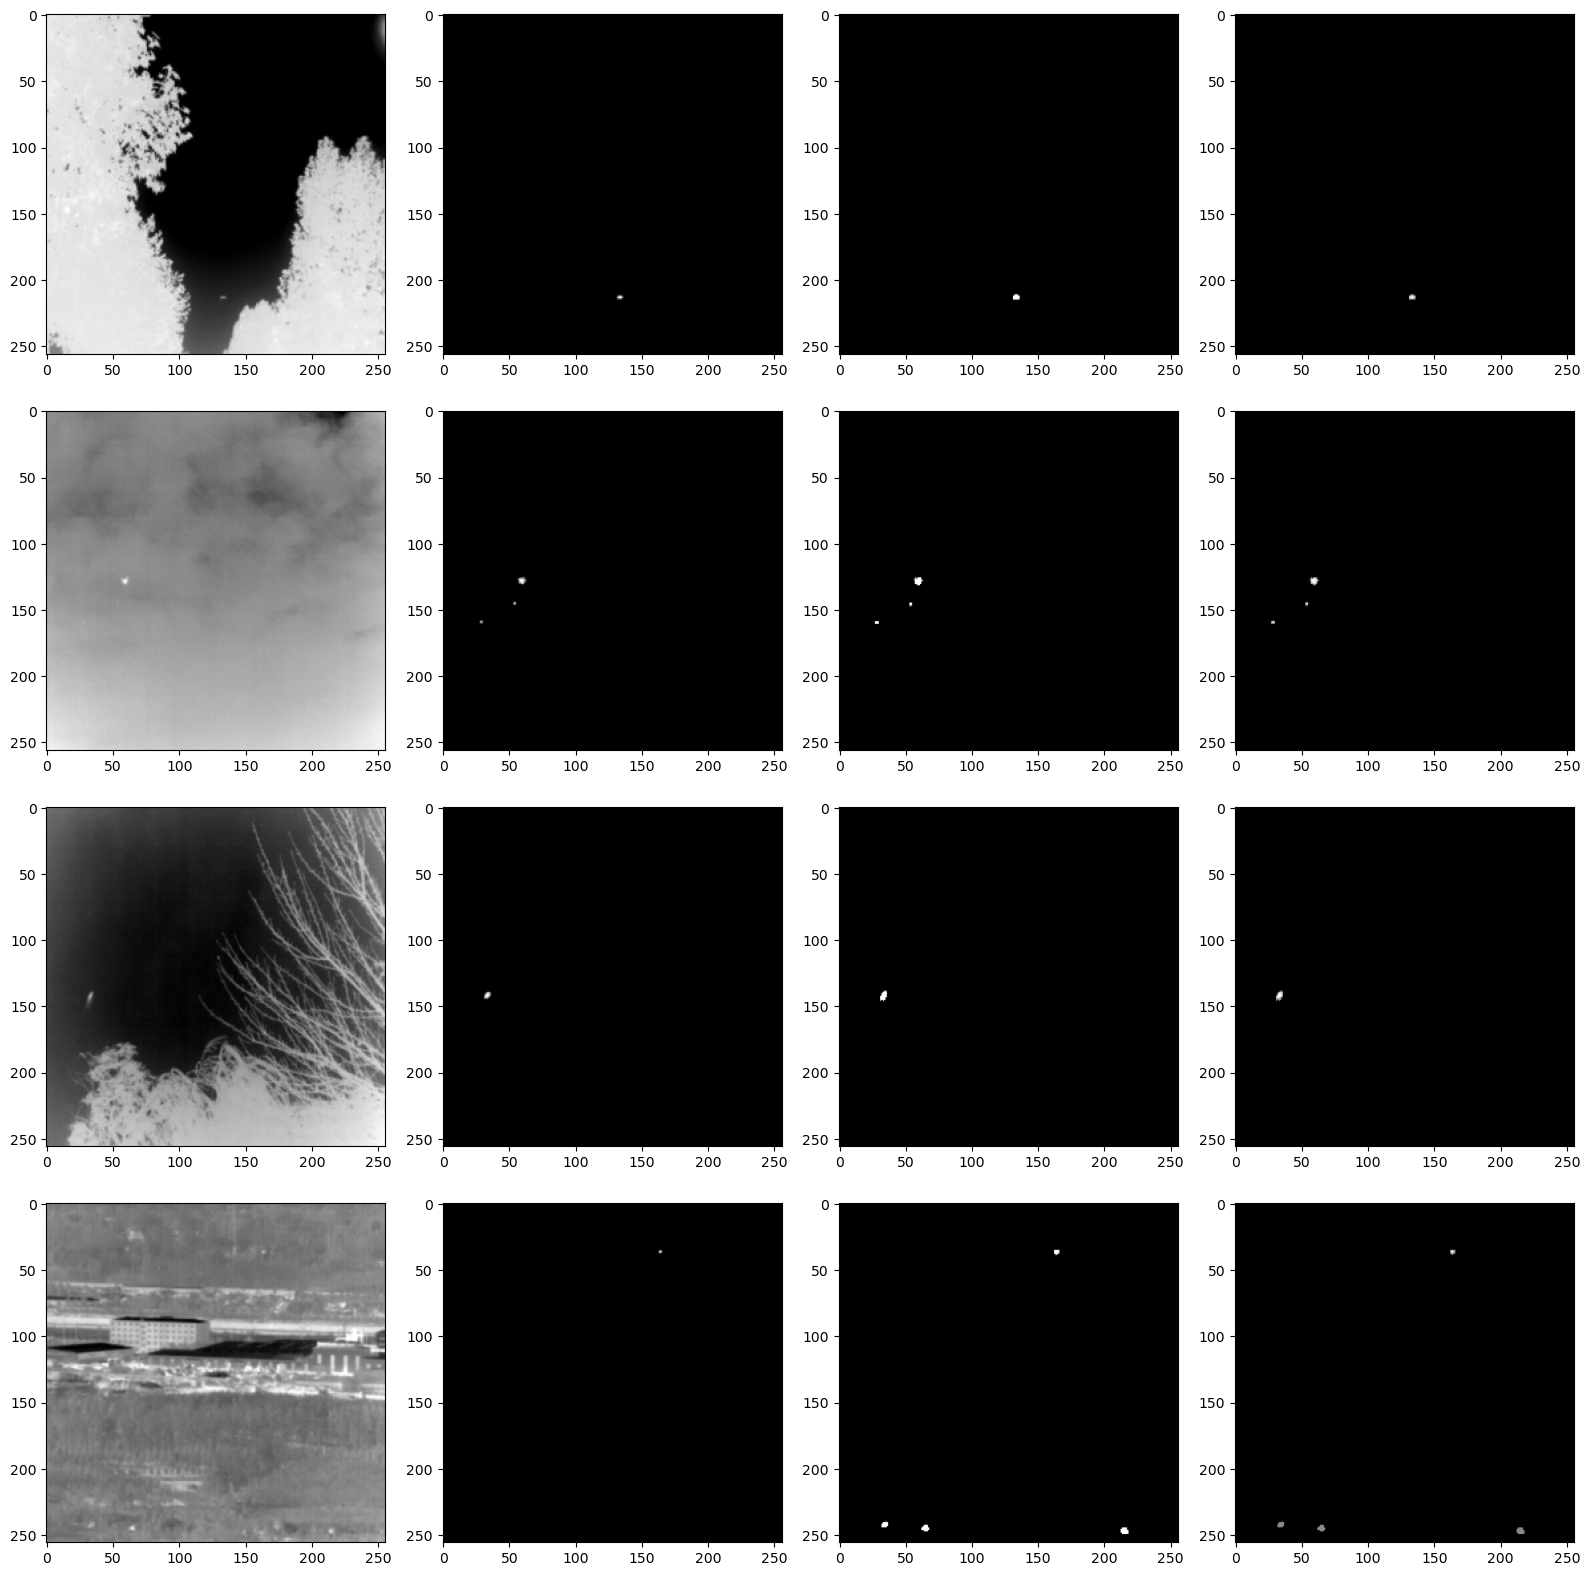

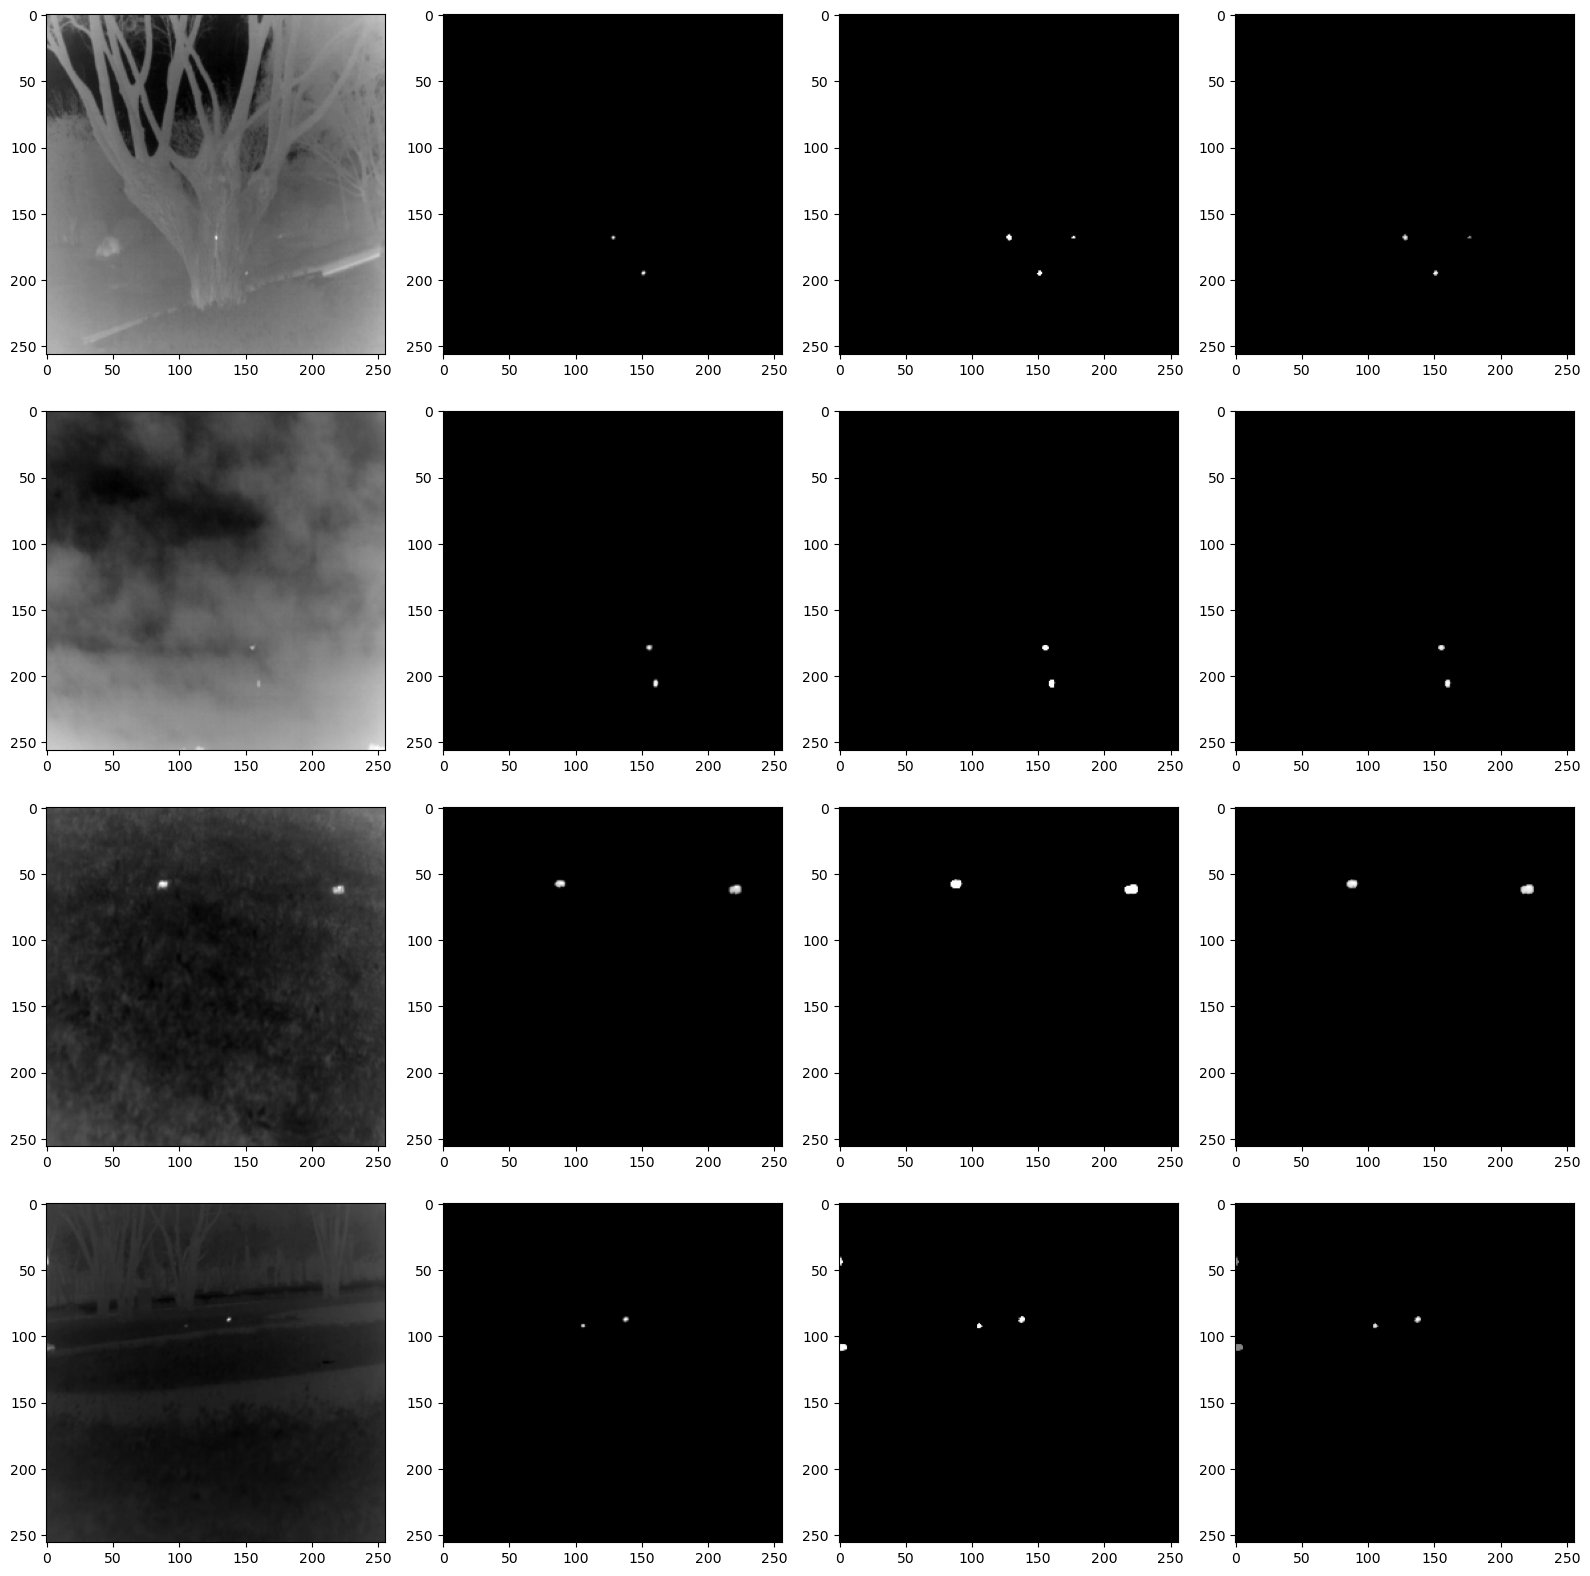

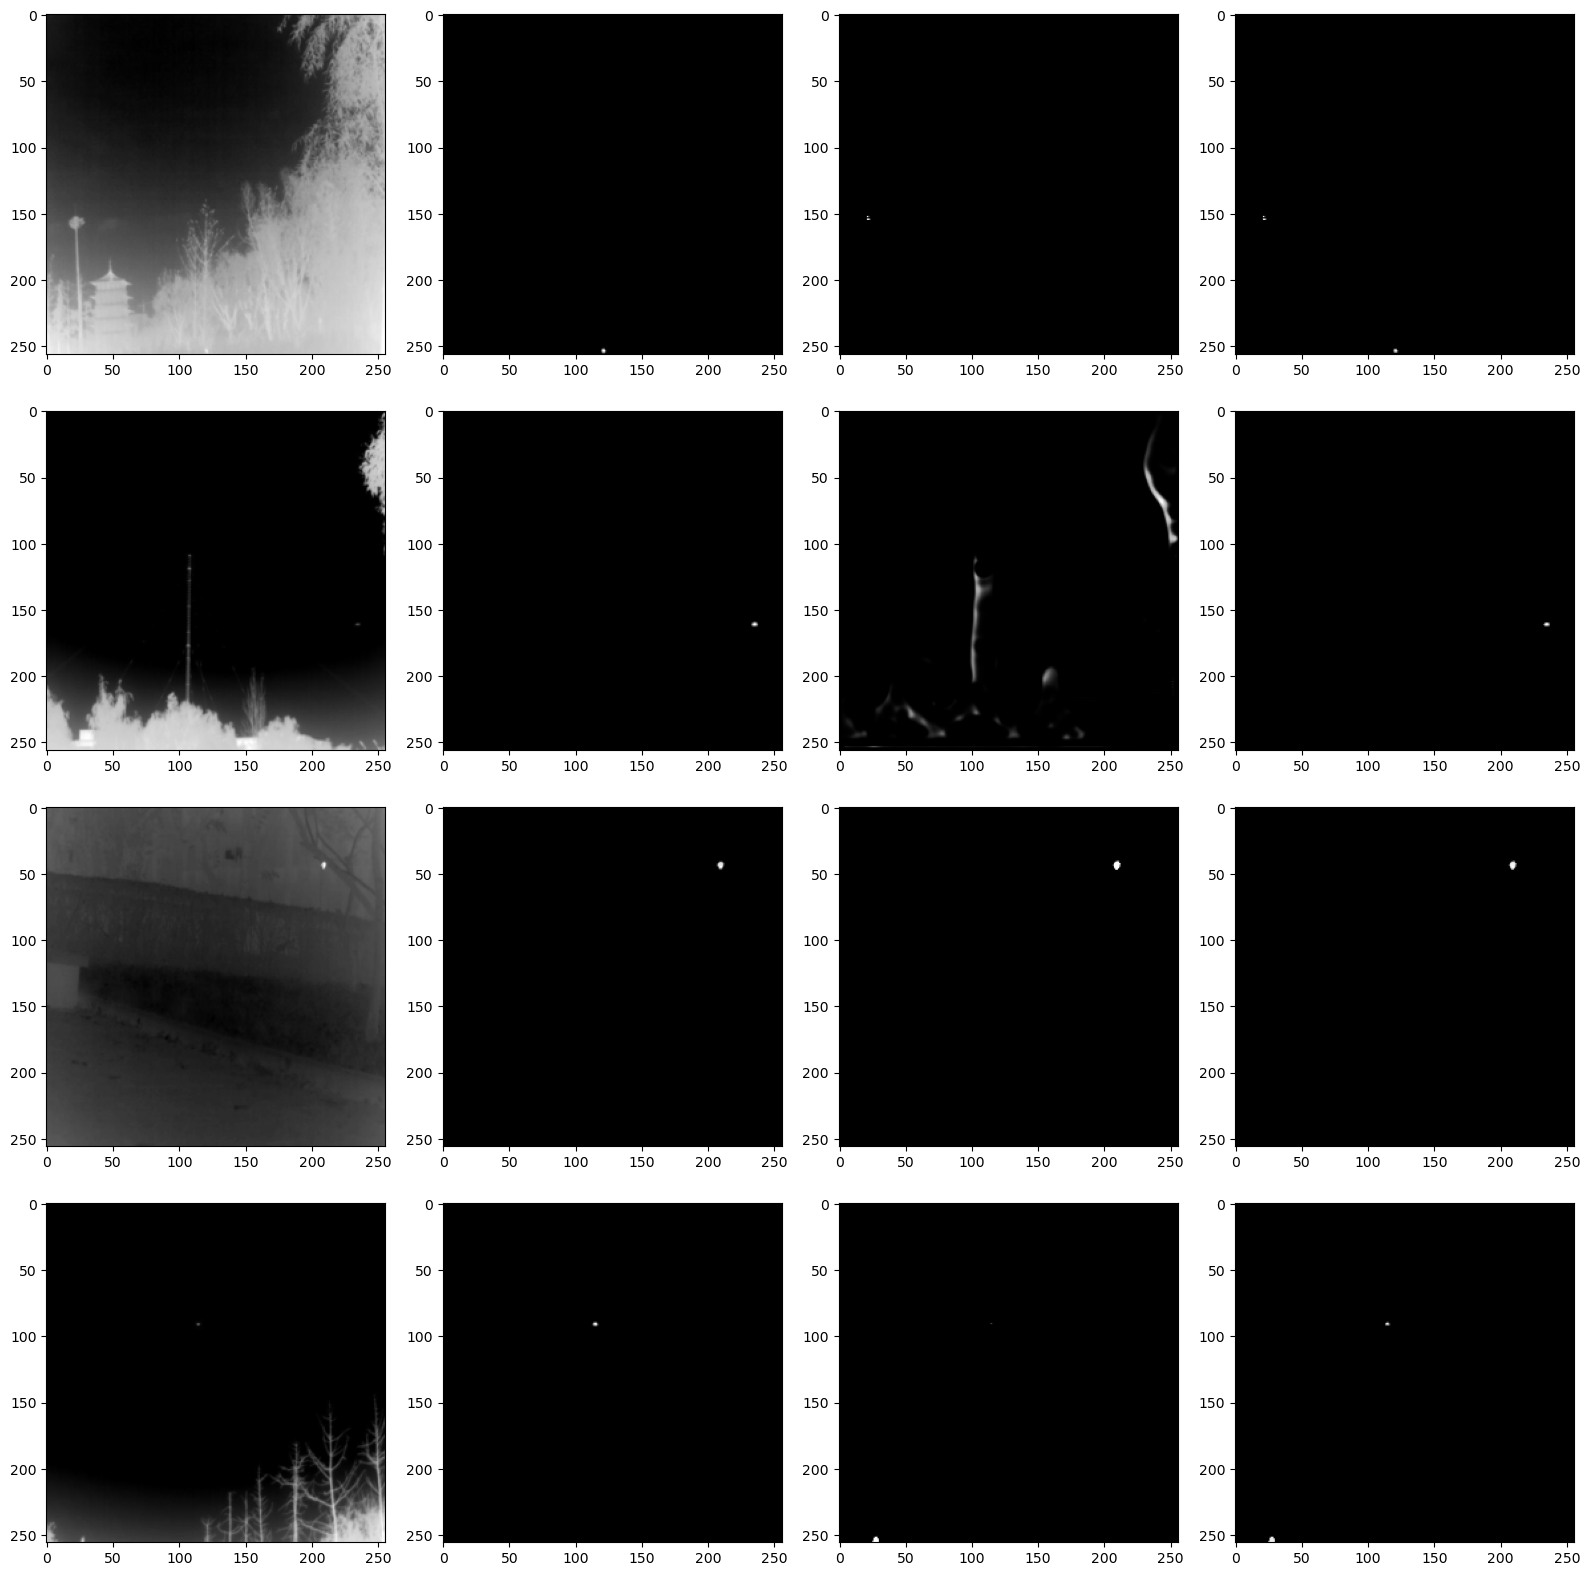

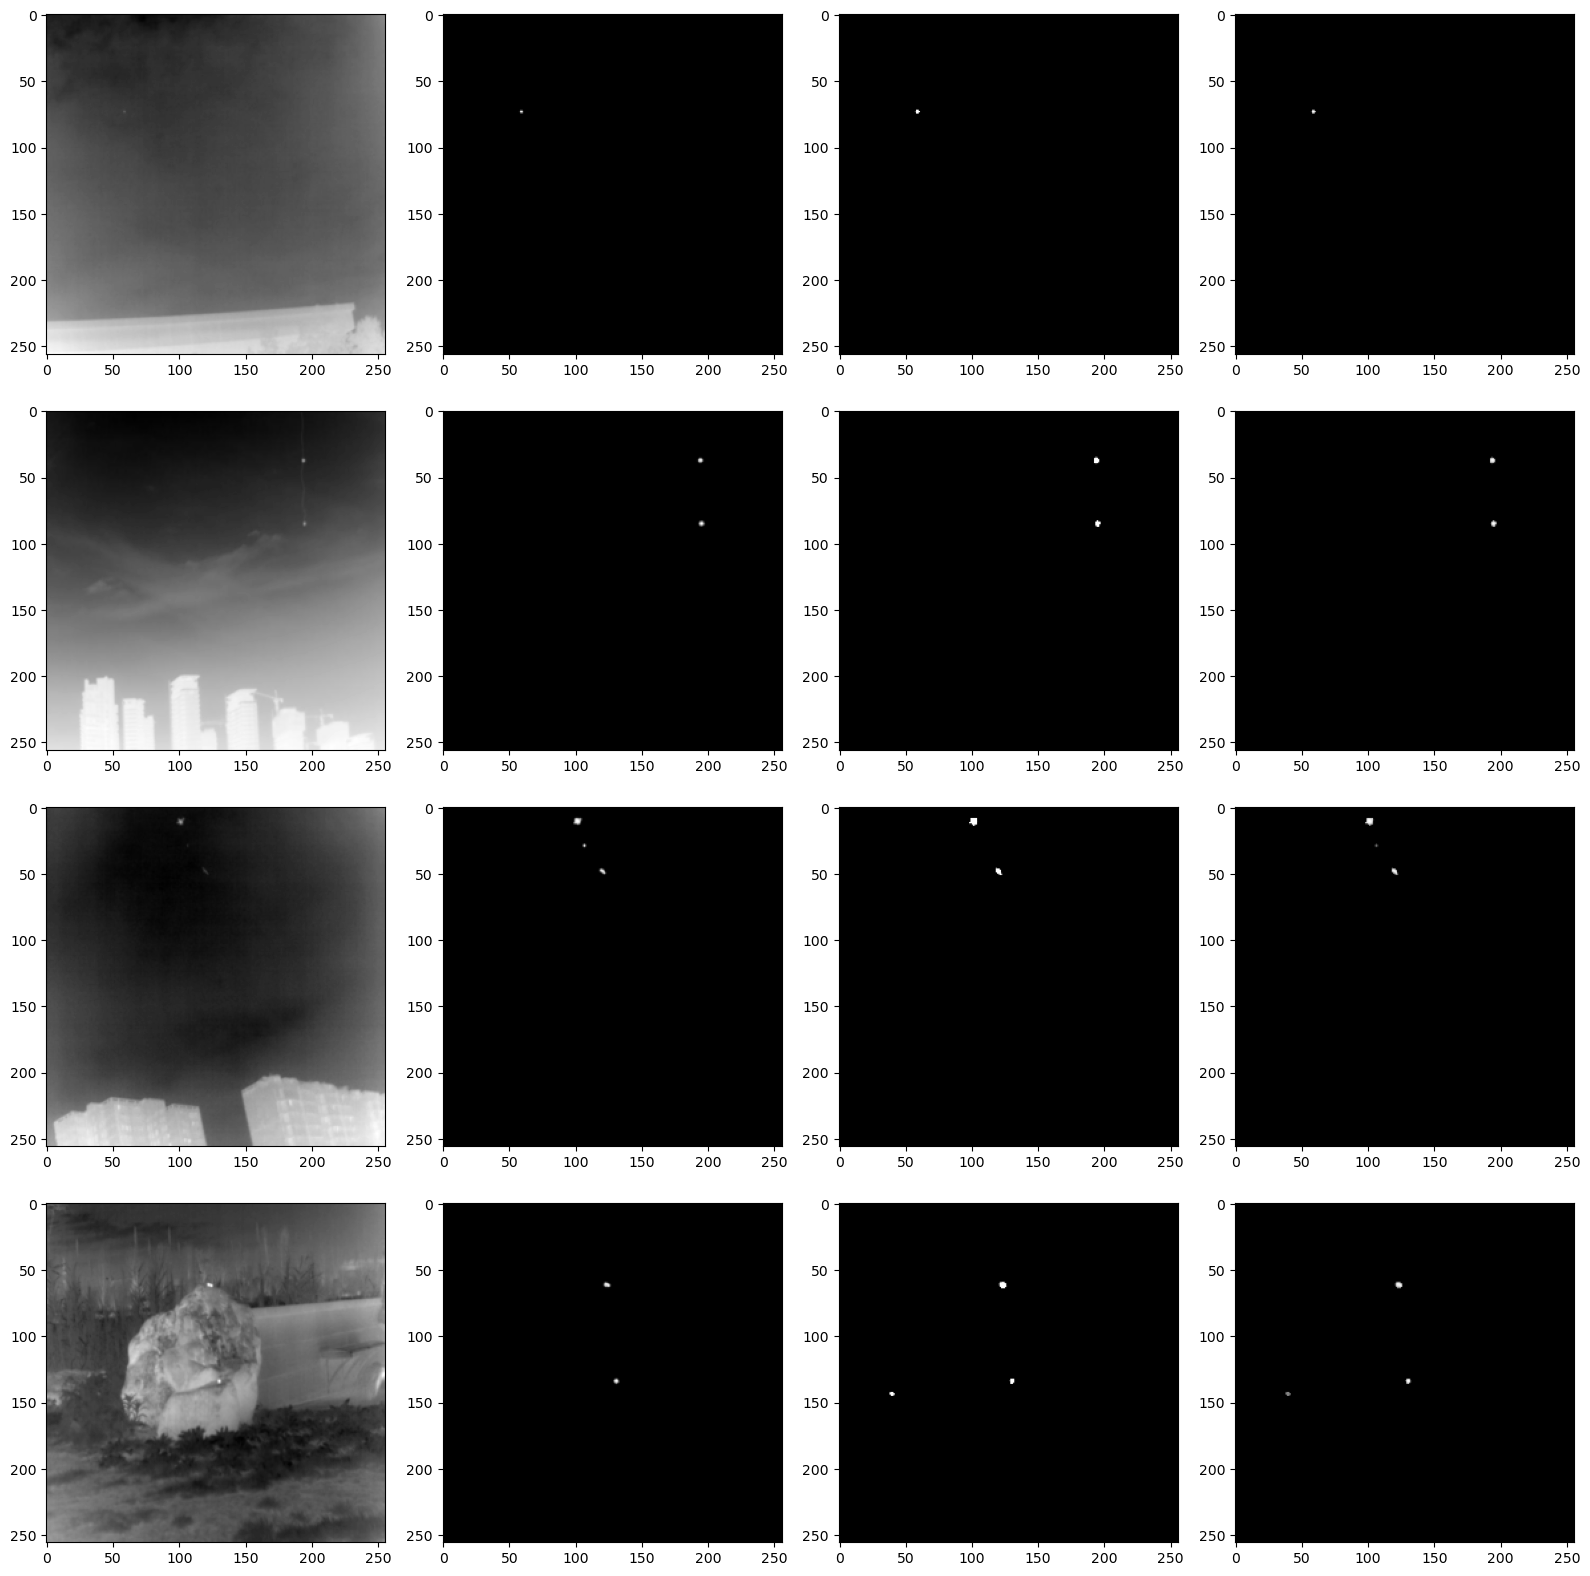

KeyboardInterrupt: Interrupted by user

In [ ]:
net_path = "W:/Projects/infraredDimTargetDetection/result/20241114T12-10-17_ws_GE_irstd1k/best.pkl"
net = attenMultiplyUNet_withloss(cfg, False)
net.load_state_dict(torch.load(net_path))
net = net.net.to('cuda')

new_pseudo_label = []
for j, (data, label) in enumerate(train_data_loader):
    data = data.to('cuda')
    preds, _, _, _ = net(data)
    preds = preds.cpu().detach()
    
    pseudo_label = (preds + label) / 2
    pseudo_label = pseudo_label * (pseudo_label > 0.1)

    data = data.cpu()

    row_num = 4
    col_num = 4
    fig, axes = plt.subplots(row_num, col_num, figsize=(col_num*4, row_num*4))
    for i in range(row_num):
        axes[i, 0].imshow(data[i,0], cmap='gray')
        # axes[i, 1].imshow(img_gradient_[i, 0], cmap='gray')
        # axes[i, 2].imshow(expanded_grad[i, 0], cmap='gray')
        # axes[i, 3].imshow(img_gradient_[i, 2], cmap='gray')
        # axes[i, 4].imshow(img_gradient_[i, 3], cmap='gray')
        # axes[i, 5].imshow(img_gradient_[i, 4], cmap='gray')
        # axes[i, 6].imshow(img_gradient_[i, 5], cmap='gray')
        # axes[i, 7].imshow(img_gradient_[i, 6], cmap='gray')
        # axes[i, 8].imshow(img_gradient_[i, 7], cmap='gray')
        axes[i, 1].imshow(label[i, 0], cmap='gray')
        axes[i, 2].imshow(preds[i, 0], cmap='gray')
        axes[i, 3].imshow(pseudo_label[i, 0], cmap='gray')
    plt.tight_layout()
    plt.show()
    a = input()

In [14]:
origin_name = os.listdir("W:/DataSets/ISTD/IRSTD-1k/trainval/images")
for i in range(len(origin_name)):
    if origin_name[i] == "XDU263.png":
        print(i)

143


In [ ]:
def normalize_image(image):
    """
    归一化图像，使最大值为1，最小值为0。
    :param image: 输入图像张量 (H, W)
    :return: 归一化后的图像张量
    """
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image

def weighted_variance(image):
    """
    计算给定图像的加权方差。
    1. 首先归一化图像，使最大值为1，最小值为0。
    2. 然后计算归一化图像的方差。
    3. 最后将方差除以像素数。
    :param image: 输入图像张量 (H, W)
    :return: 加权方差
    """
    # 确保输入是二维张量
    assert image.dim() == 2, "Input should be a 2D tensor."
    # 归一化图像
    normalized_image = normalize_image(image)
    # 计算归一化图像的方差
    variance = torch.var(normalized_image, unbiased=False)
    return variance, normalized_image

def selectionWithVar(image, x1, y1, x2, y2):
    var_p = torch.tensor([1e8,], dtype=torch.float32)
    img = torch.tensor([])
    for i in range(x1.shape[0]):
        region = image[y1[i]:y2[i], x1[i]:x2[i]]
        var, normalized_region = weighted_variance(region)
        print(var)
        if torch.abs(var - 0.25) < torch.abs(var_p - 0.25):
            var_p = var
            img = normalized_region
        # 显示结果
        plt.figure(figsize=(12, 6))
        plt.subplot(141), plt.imshow(region, cmap='gray'), plt.title(f'var:{var.item()}')
        plt.subplot(142), plt.imshow(region, cmap='gray'), plt.title(f'var:{var.item()}')
        plt.show()

        # if region.shape != (region_size, region_size):
        #     region = torch.nn.functional.pad(region, (0, region_size - region.shape[1], 0, region_size - region.shape[0]), mode='reflect')
        
        a = input()
    return img

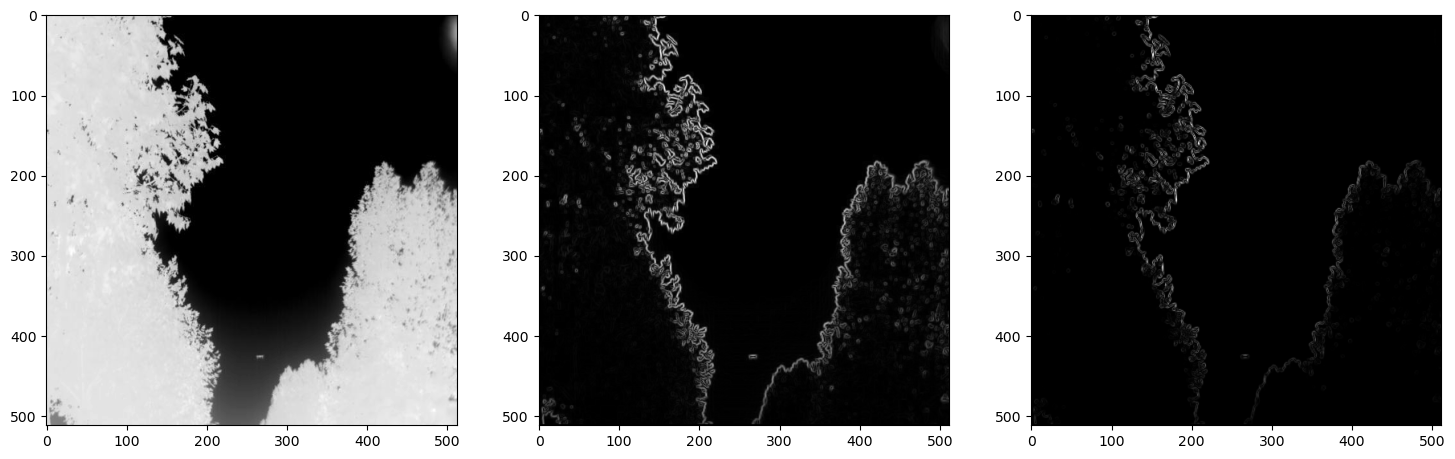

KeyboardInterrupt: Interrupted by user

In [10]:
for j, (data, label) in enumerate(train_data_loader):
    B, _, S, _ = data.shape
    img_gradient_ = img_gradient(data[:1])
    # expanded_grad = img_gradient_
    # for i in range(16):
    #     expanded_grad = gradient_expand(expanded_grad, 1.0)
    img_gradient_2 = img_gradient(torch.sum(img_gradient_, dim=1, keepdim=True))
    # # 过滤
    # target = torch.sum(expanded_grad[0], dim=0)
    # mean_val = (torch.max(target) + torch.mean(target))/2
    # target = torch.where(target > mean_val, target, torch.zeros_like(target))
    # 显示结果
    plt.figure(figsize=(18, 6))
    plt.subplot(131), plt.imshow(data[0,0], cmap='gray')
    plt.subplot(132), plt.imshow(torch.sum(img_gradient_[0], dim=0), cmap='gray')
    plt.subplot(133), plt.imshow(torch.sum(img_gradient_2[0], dim=0) * torch.sum(img_gradient_[0], dim=0), cmap='gray') 
    plt.show()

    # if region.shape != (region_size, region_size):
    #     region = torch.nn.functional.pad(region, (0, region_size - region.shape[1], 0, region_size - region.shape[0]), mode='reflect')
    
    a = input()

In [ ]:
trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=256, cfg=cfg)
train_data_loader = Data.DataLoader(trainset, batch_size=8, shuffle=False)

def img_gradient(image_batch):
    # 定义 Sobel 算子
    sobel = torch.tensor([[[[-0.25, 0., 0.25],
                            [-2., 0., 2.],
                            [-0.25, 0., 0.25]]],
                          [[[ 0.25, 2., 0.25],
                            [ 0., 0., 0.],
                            [-0.25,-2.,-0.25]]],
                          [[[ 2., 0.25, 0.],
                            [ 0.25, 0.,-0.25],
                            [ 0.,-0.25,-2.]]],
                          [[[ 0., 0.25, 2.],
                            [-0.25, 0., 0.25],
                            [-2.,-0.25, 0.]]]], dtype=image_batch.dtype, device=image_batch.device)
    gradient = F.conv2d(image_batch, sobel, padding=1)  # (B, 4, S, S)
    zeros_tensor = torch.zeros_like(gradient[:,:1])
    grad_top = torch.where(gradient[:,1:2]>0, gradient[:,1:2], zeros_tensor)
    grad_topleft = torch.where(gradient[:,2:3]>0, gradient[:,2:3], zeros_tensor)
    grad_topright = torch.where(gradient[:,3:4]>0, gradient[:,3:4], zeros_tensor)
    grad_right = torch.where(gradient[:,:1]>0, gradient[:,:1], zeros_tensor)
    grad_bot = torch.where(gradient[:,1:2]<0, -gradient[:,1:2], zeros_tensor)
    grad_botleft = torch.where(gradient[:,2:3]<0, -gradient[:,2:3], zeros_tensor)
    grad_botright = torch.where(gradient[:,3:4]<0, -gradient[:,3:4], zeros_tensor)
    grad_left = torch.where(gradient[:,:1]<0, -gradient[:,:1], zeros_tensor)
    grad = torch.concatenate((grad_top, grad_bot, grad_right, grad_left, grad_topleft, grad_botright, grad_topright, grad_botleft), dim=1)
    grad[:,:,:1]=0
    grad[:,:,-1:]=0
    grad[:,:,:,:1]=0
    grad[:,:,:,-1:]=0
    return grad

def  gradient_expand(gradient, rate):
    op1 = torch.tensor([[[[0.9, 0.05, 0.0],
                          [0.05, 0.0, 0.0],
                          [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op2 = torch.tensor([[[[0.05, 0.9, 0.05],
                          [0.0, 0.0, 0.0],
                          [0.0, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate
    op3 = torch.tensor([[[[0.05, 0.0, 0.0],
                          [0.9, 0.0, 0.0],
                          [0.05, 0.0, 0.0]]]], dtype=gradient.dtype, device=gradient.device) * rate

    grad_top = F.conv2d(gradient[:,:1], torch.flip(op2, dims=[2]), padding=1)
    grad_bot = F.conv2d(gradient[:,1:2], op2, padding=1)
    grad_right = F.conv2d(gradient[:,2:3], op3, padding=1)
    grad_left = F.conv2d(gradient[:,3:4], torch.flip(op3, dims=[3]), padding=1)
    grad_topleft = F.conv2d(gradient[:,4:5], torch.flip(op1, dims=[2,3]), padding=1)
    grad_botright = F.conv2d(gradient[:,5:6], op1, padding=1)
    grad_topright = F.conv2d(gradient[:,6:7], torch.flip(op1, dims=[2]), padding=1)
    grad_botleft = F.conv2d(gradient[:,7:8], torch.flip(op1, dims=[3]),padding=1)
    gradient_ = torch.concatenate((grad_top, grad_bot, grad_right, grad_left, grad_topleft, grad_botright, grad_topright, grad_botleft), dim=1)
    gradient_ = torch.where(gradient*rate > gradient_, gradient, gradient_)
    return gradient_

def dilate_labels(labels, dilation_kernel_size=5):
    # 创建一个膨胀内核
    kernel = torch.ones(1, 1, dilation_kernel_size, dilation_kernel_size, device=labels.device)
    
    # 应用膨胀操作
    dilated_labels = F.conv2d(labels, kernel, padding=dilation_kernel_size//2)
    dilated_labels = (dilated_labels > 0).float()  # 转换为二值标签
    
    return dilated_labels
"""
def gradient_optim(gradient): 
    b, c, s, _ = gradient.shape
    kernnel_size = 64
    max_num = F.max_pool2d(gradient, kernnel_size, kernnel_size//2, kernnel_size//2)
    min_num = - F.max_pool2d(-gradient, kernnel_size, kernnel_size//2, kernnel_size//2)
    max_num = F.interpolate(max_num, scale_factor=int(kernnel_size//2))
    min_num = F.interpolate(min_num, scale_factor=int(kernnel_size//2))
    max_num = max_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]
    min_num = min_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]
    gradient = torch.where(max_num-min_num > 0.5, gradient, torch.zeros_like(gradient))
    # mean_num = torch.mean((max_num-min_num).view(b,c,s*s), dim=2)
    # avg_num = F.avg_pool2d(gradient, 3, 1, 1)
    _gradient = (gradient-min_num)/(max_num-min_num)
    return torch.where(_gradient>0.8, torch.ones_like(_gradient), torch.zeros_like(_gradient))
"""

'\ndef gradient_optim(gradient): \n    b, c, s, _ = gradient.shape\n    kernnel_size = 64\n    max_num = F.max_pool2d(gradient, kernnel_size, kernnel_size//2, kernnel_size//2)\n    min_num = - F.max_pool2d(-gradient, kernnel_size, kernnel_size//2, kernnel_size//2)\n    max_num = F.interpolate(max_num, scale_factor=int(kernnel_size//2))\n    min_num = F.interpolate(min_num, scale_factor=int(kernnel_size//2))\n    max_num = max_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]\n    min_num = min_num[:,:,kernnel_size//4:-kernnel_size//4, kernnel_size//4:-kernnel_size//4]\n    gradient = torch.where(max_num-min_num > 0.5, gradient, torch.zeros_like(gradient))\n    # mean_num = torch.mean((max_num-min_num).view(b,c,s*s), dim=2)\n    # avg_num = F.avg_pool2d(gradient, 3, 1, 1)\n    _gradient = (gradient-min_num)/(max_num-min_num)\n    return torch.where(_gradient>0.8, torch.ones_like(_gradient), torch.zeros_like(_gradient))\n'

tensor(1.7469)


KeyboardInterrupt: Interrupted by user

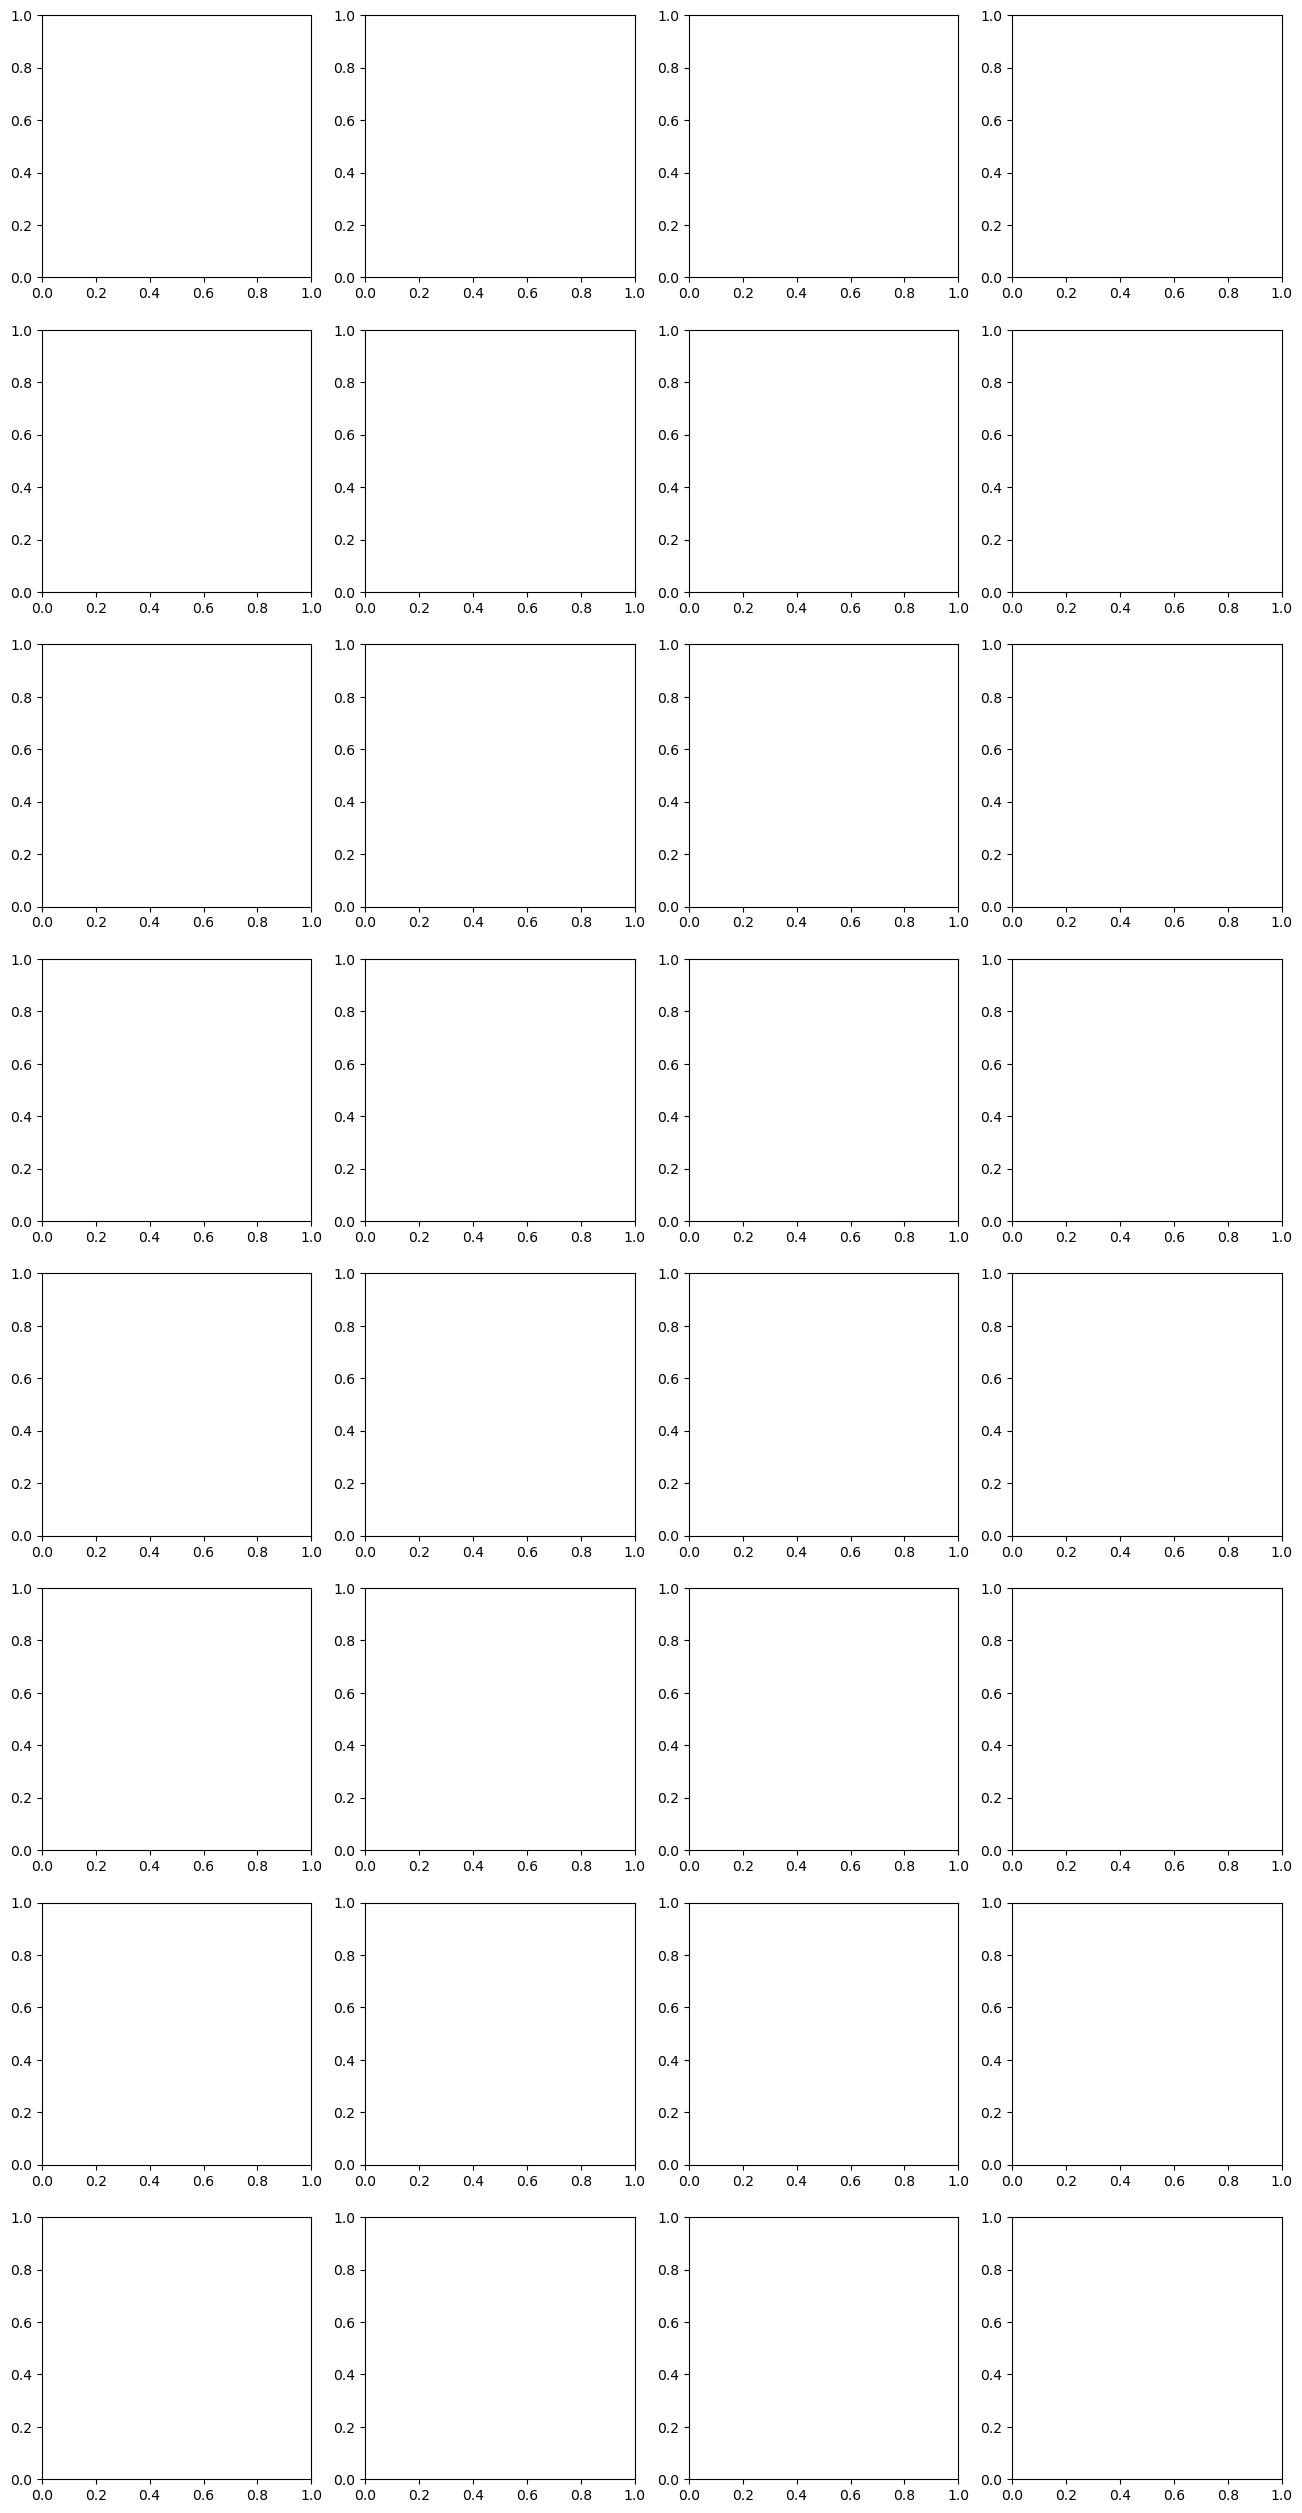

In [ ]:
for j, (data, label) in enumerate(train_data_loader):
    img_gradient_ = img_gradient(data)
    # print(torch.max(img_gradient_[0]))
    expanded_grad = img_gradient_
    for i in range(16):
        expanded_grad = gradient_expand(expanded_grad, 1.0)
    row_num = label.shape[0]
    col_num = 4
    fig, axes = plt.subplots(row_num, col_num, figsize=(col_num*4, row_num*4))
    for i in range(row_num):
        axes[i, 0].imshow(data[i,0], cmap='gray')
        # axes[i, 1].imshow(img_gradient_[i, 0], cmap='gray')
        # axes[i, 2].imshow(expanded_grad[i, 0], cmap='gray')
        # axes[i, 3].imshow(img_gradient_[i, 2], cmap='gray')
        # axes[i, 4].imshow(img_gradient_[i, 3], cmap='gray')
        # axes[i, 5].imshow(img_gradient_[i, 4], cmap='gray')
        # axes[i, 6].imshow(img_gradient_[i, 5], cmap='gray')
        # axes[i, 7].imshow(img_gradient_[i, 6], cmap='gray')
        # axes[i, 8].imshow(img_gradient_[i, 7], cmap='gray')
        axes[i, 1].imshow(torch.sum(img_gradient_[i], dim=0), cmap='gray')
        axes[i, 2].imshow(torch.sum(expanded_grad[i], dim=0), cmap='gray')
        axes[i, 3].imshow(label[i,0], cmap='gray')
    plt.tight_layout()
    plt.show()
    a = input()

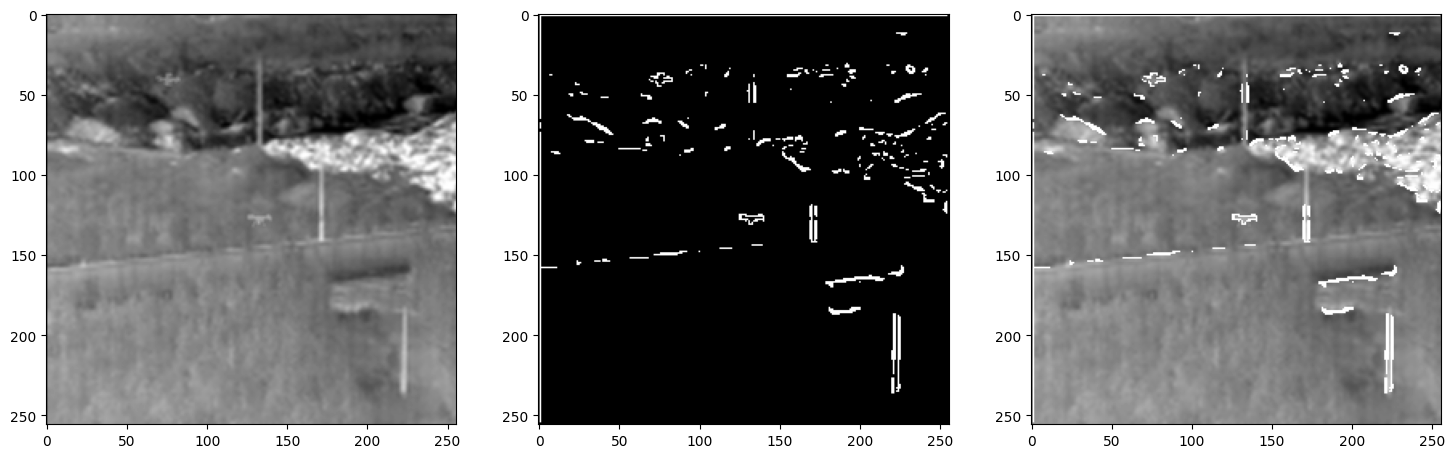

In [ ]:
# 读取图像并转换为Tensor
image_path = "W:/DataSets/ISTD/NUDT-SIRST/trainval/images/000491.png"  # 替换为你的图片路径
image = Image.open(image_path).convert('L')  # 转换为灰度图
transform = transforms.ToTensor()
tensor_image = transform(image)

# 将Tensor转换到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_image = tensor_image.to(device)

img_gradient = gradient(tensor_image.unsqueeze(0))
img_gradient = gradient_optim(img_gradient)

# 显示结果
plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(tensor_image.cpu().squeeze(0), cmap='gray')
plt.subplot(132), plt.imshow(img_gradient.cpu().squeeze(0).squeeze(0), cmap='gray')
synthetic_pict = torch.max(tensor_image.cpu().squeeze(0), img_gradient.cpu().squeeze(0).squeeze(0))
plt.subplot(133), plt.imshow(synthetic_pict, cmap='gray') 
plt.show()

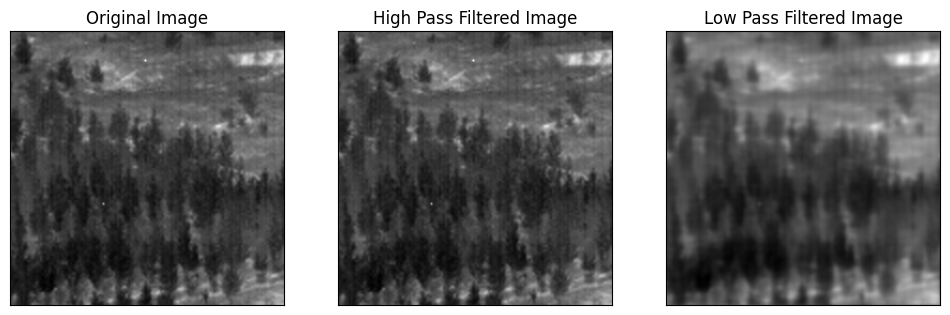

In [26]:
# 读取图像并转换为Tensor
image_path = 'W:/DataSets/ISTD/NUDT-SIRST/trainval/images/000358.png'  # 替换为你的图片路径
image = Image.open(image_path).convert('L')  # 转换为灰度图
transform = transforms.ToTensor()
tensor_image = transform(image)

# 将Tensor转换到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_image = tensor_image.to(device)

# 对图像进行FFT变换
fft_image = torch.fft.fftn(tensor_image, dim=(-2, -1))

# 创建滤波器
def create_filter(shape, cutoff, high_pass=True):
    """ 创建一个高通或低通滤波器 """
    H, W = shape
    x, y = torch.meshgrid(torch.arange(W), torch.arange(H))
    x, y = x - (W // 2), y - (H // 2)
    distance = torch.sqrt(x**2 + y**2)
    filter_ = 1.0 - 1.0 / (1.0 + (cutoff / distance)**(2 * 4))  # Butterworth滤波器
    return filter_ if high_pass else 1.0 - filter_

# 图像尺寸
H, W = fft_image.shape[-2:]

# 设置截止频率
cutoff_high = 300  # 高通滤波器的截止频率
cutoff_low = 400   # 低通滤波器的截止频率

# 创建高通和低通滤波器
high_pass_filter = create_filter((H, W), cutoff_high, high_pass=True).to(device)
low_pass_filter = create_filter((H, W), cutoff_low, high_pass=False).to(device)

# 应用滤波器
filtered_fft_high = fft_image * high_pass_filter
filtered_fft_low = fft_image * low_pass_filter

# 通过逆FFT将频域数据转回空间域
ifft_image_high = torch.fft.ifftn(filtered_fft_high, dim=(-2, -1)).real
ifft_image_low = torch.fft.ifftn(filtered_fft_low, dim=(-2, -1)).real

# 显示结果
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(tensor_image.cpu().squeeze(0), cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(ifft_image_high.cpu().squeeze(0), cmap='gray')
plt.title('High Pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(ifft_image_low.cpu().squeeze(0), cmap='gray')
plt.title('Low Pass Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
from dataprocess.sirst_point import IRSTD1kDataset
import yaml
import torch.utils.data as Data

cfg_path = 'cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

trainset = IRSTD1kDataset(base_dir=r"W:/DataSets/ISTD/IRSTD-1k", mode="train", base_size=256, pt_label=True, cfg=cfg)
train_data_loader = Data.DataLoader(trainset, batch_size=4, shuffle=False)

In [ ]:
def point2mask(img, ptlabel):
    """
    acorrding to the point,
    """

In [16]:
import torch
import torch.nn as nn

def normalize_tensor(tensor):
        B, C, H, W = tensor.shape
        # 获取最小值和最大值
        min_vals, _ = tensor.view(B, C, -1).min(dim=-1, keepdim=True)
        max_vals, _ = tensor.view(B, C, -1).max(dim=-1, keepdim=True)
        # 防止除零错误
        range_vals = max_vals - min_vals
        range_vals[range_vals == 0] = 1e8  # 如果最大值和最小值相等，设为1避免除零错误
        range_vals = range_vals.unsqueeze(-1).repeat(1,1,H,W)
        min_vals = min_vals.unsqueeze(-1).repeat(1,1,H,W)
        # 归一化
        normalized_tensor = (tensor - min_vals) / range_vals
        return normalized_tensor

In [17]:
# net = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1, output_padding=0)
# net = nn.Conv2d(1, 2, 3, 4, padding=4, dilation=4)
a = torch.randn((1,1,4,4))
print(a)
b = normalize_tensor(a)
print(b)

tensor([[[[ 1.1701, -1.4634, -0.9587,  0.3685],
          [-0.1992, -0.4930,  0.7706,  0.3067],
          [ 0.1911, -0.6214,  0.2227,  0.8455],
          [-0.5921,  0.1497, -0.1599, -0.1637]]]])
tensor([[[[1.0000, 0.0000, 0.1917, 0.6956],
          [0.4801, 0.3685, 0.8483, 0.6721],
          [0.6283, 0.3197, 0.6403, 0.8767],
          [0.3309, 0.6125, 0.4950, 0.4935]]]])


tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000, 19.9998, 20.7499, 21.2857, 22.2000,
        22.5000, 23.3333, 24.5000, 25.1818, 26.1212, 26.9643, 27.7749, 28.6489,
        29.2215, 29.7903, 30.2536, 30.7787, 31.2164, 31.6152, 32.0574, 32.4029,
        32.5699, 32.9005, 33.1410, 33.3534, 33.5042, 33.6011, 33.6185, 33.6746,
        33.7739, 33.8370, 33.9918, 34.1531, 34.3681, 34.4920, 34.6209, 34.8340,
        34.9714, 35.1135, 35.1725, 35.1725, 35.3312, 35.4618, 35.5627, 35.7011,
        35.7368, 35.9925, 36.1787, 36.2930, 36.4490, 36.5686, 36.7722, 36.8968,
        37.0664, 37.1961, 37.3285, 37.4636, 37.5095, 37.7438, 37.8865, 38.0318,
        38.0812, 38.2321, 38.2834, 38.4918, 38.7555, 38.9157, 39.1322, 39.3513,
        39.5177, 39.5740, 39.5740, 39.5740, 39.8709, 39.9310, 40.1139, 40.3603,
        40.5470, 40.6730, 40.6730, 40.80

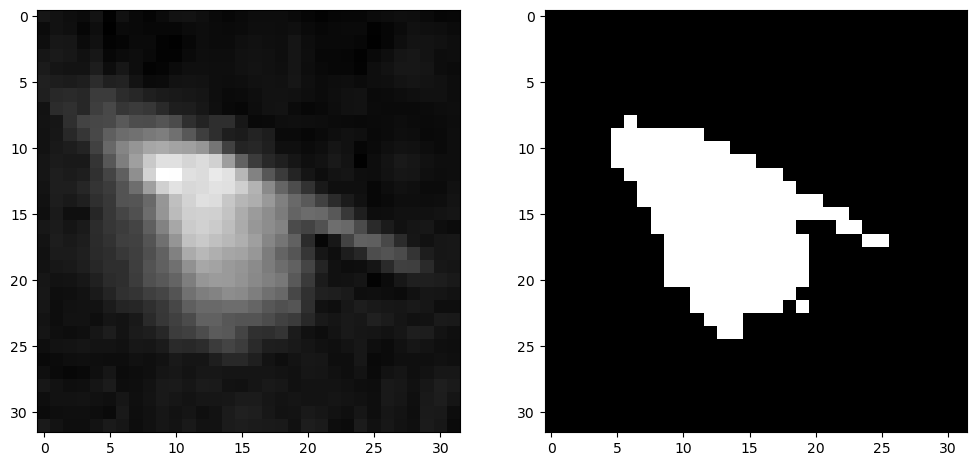

In [ ]:
def otsu_threshold(image):
    # 将图像转换为PyTorch张量
    image_tensor = torch.tensor(image, dtype=torch.float32)
    
    # 计算直方图
    hist = torch.histc(image_tensor, bins=256, min=0, max=255)
    hist = hist / hist.sum()  # 归一化直方图
    
    # 计算累积概率
    cum_hist = torch.cumsum(hist, dim=0)
    
    # 计算累积均值
    cum_mean = torch.cumsum(hist * torch.arange(256, dtype=torch.float32), dim=0)
    
    # 总均值
    total_mean = cum_mean[-1]
    
    # 计算背景和目标的均值
    smooth = 1e-8
    mean_b = cum_mean / (cum_hist + smooth)
    mean_f = (total_mean - cum_mean) / (1 - cum_hist + smooth)
    
    # 计算类间方差
    between_var = cum_hist * (1 - cum_hist) * (mean_b - mean_f) ** 2
    
    # 找到最大类间方差对应的阈值
    max_var_idx = torch.argmax(between_var)
    threshold = max_var_idx.item()
    
    return threshold

# 读取图像并转换为灰度图像
img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/crop32images/XDU62_01.png"
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 使用Otsu's 方法计算最优阈值
threshold = otsu_threshold(image)
print(threshold)

# 将图像二值化
binary_image = (image >= threshold).astype(np.uint8) * 255

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.subplot(122), plt.imshow(binary_image, cmap='gray')
plt.show()

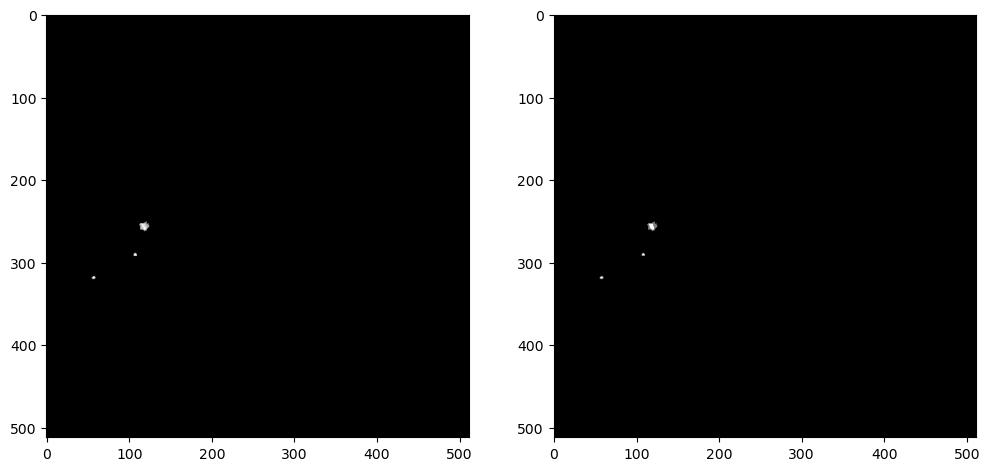

In [ ]:
 
    # 将图像转换为PyTorch张量
    image_tensor = torch.tensor(image, dtype=torch.float32)
    
    # 计算直方图
    hist = torch.histc(image_tensor, bins=256, min=0, max=255)
    hist = hist / hist.sum()  # 归一化直方图
    
    # 计算累积概率和累积均值
    cum_hist = torch.cumsum(hist, dim=0)
    cum_mean = torch.cumsum(hist * torch.arange(256, dtype=torch.float32), dim=0)
    
    # 总均值
    total_mean = cum_mean[-1]
    
    # 创建所有可能的阈值组合
    t1 = torch.arange(1, 255, dtype=torch.int64)
    t2 = torch.arange(1, 255, dtype=torch.int64)
    
    # 生成网格
    t1_grid, t2_grid = torch.meshgrid(t1, t2, indexing='ij')
    
    # 计算各部分的权重
    w0 = cum_hist[t1_grid - 1]
    w1 = cum_hist[t2_grid - 1] - cum_hist[t1_grid - 1]
    w2 = 1 - cum_hist[t2_grid - 1]
    
    # 排除无效的权重组合
    valid_mask = (w0 > 0) & (w1 > 0) & (w2 > 0)
    
    # 计算各部分的均值
    smooth = 1e-8
    mean0 = cum_mean[t1_grid - 1] / (w0 + smooth)
    mean1 = (cum_mean[t2_grid - 1] - cum_mean[t1_grid - 1]) / (w1 + smooth)
    mean2 = (total_mean - cum_mean[t2_grid - 1]) / (w2 + smooth)
    
    # 计算类间方差
    between_var = w0 * (mean0 - total_mean) ** 2 + w1 * (mean1 - total_mean) ** 2 + w2 * (mean2 - total_mean) ** 2
    
    # 只考虑有效的权重组合
    between_var[~valid_mask] = 0
    
    # 找到最大类间方差对应的阈值
    max_var_idx = torch.argmax(between_var)
    optimal_t1, optimal_t2 = t1_grid.flatten()[max_var_idx], t2_grid.flatten()[max_var_idx]
    
    return [optimal_t1.item(), optimal_t2.item()]

# 读取图像并转换为灰度图像
img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/pixel_pseudo_label/XDU1.png"
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# 使用多阈值Otsu's 方法计算最优阈值
thresholds = multi_otsu_threshold(image)

trinary_image = torch.zeros_like(torch.tensor(image, dtype=torch.uint8))
trinary_image[image >= thresholds[1]] = 255
trinary_image[(image >= thresholds[0]) & (image < thresholds[1])] = 128

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.subplot(122), plt.imshow(trinary_image, cmap='gray')
plt.show()

In [1]:
from net.attentionnet import attenMultiplyUNet3

import yaml

cfg_path = 'cfg.yaml'
with open(cfg_path) as f:
    cfg = yaml.safe_load(f)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [2]:
net = attenMultiplyUNet3(cfg)
num = count_parameters(net)
print(num)

8703554


In [1]:
from utils.loss import Detail_loss
import torch
import cv2
import matplotlib.pyplot as plt

net = Detail_loss(3)

In [2]:
# 读取图像并转换为灰度图像
img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images/XDU1.png"
image = torch.from_numpy(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)).float()/255
mask_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/pixel_pseudo_label0/XDU1.png"
mask = torch.from_numpy(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)).float()/255

image = image.unsqueeze(0).unsqueeze(0)
mask = mask.unsqueeze(0).unsqueeze(0)
preds = mask.clone()
loss, cropped_imgs = net(preds, mask, image)

0.6039215686274509 0.7529411764705882


In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_path = img_path = "W:/DataSets/ISTD/IRSTD-1k/trainval/images/XDU992.png"

def adaptive_canny_based_on_histogram(image):
    """
    使用基于图像直方图的自适应Canny边缘检测。
    
    参数:
        image (numpy.ndarray): 输入的灰度图像，形状为 (H, W).
        
    返回:
        numpy.ndarray: 经过Canny边缘检测处理后的二值图像，形状为 (H, W).
    """
    # 确保输入的是单通道灰度图像
    if len(image.shape) != 2:
        raise ValueError("输入图像必须是单通道灰度图像")

    # 使用Otsu's方法找到全局阈值
    val, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 设置低阈值和高阈值为Otsu阈值的一定比例
    # low_threshold = int(0.5 * val)
    high_threshold = int(val)
    
    # 应用Canny边缘检测
    edges = cv2.Canny(image, 0, high_threshold)

    return edges

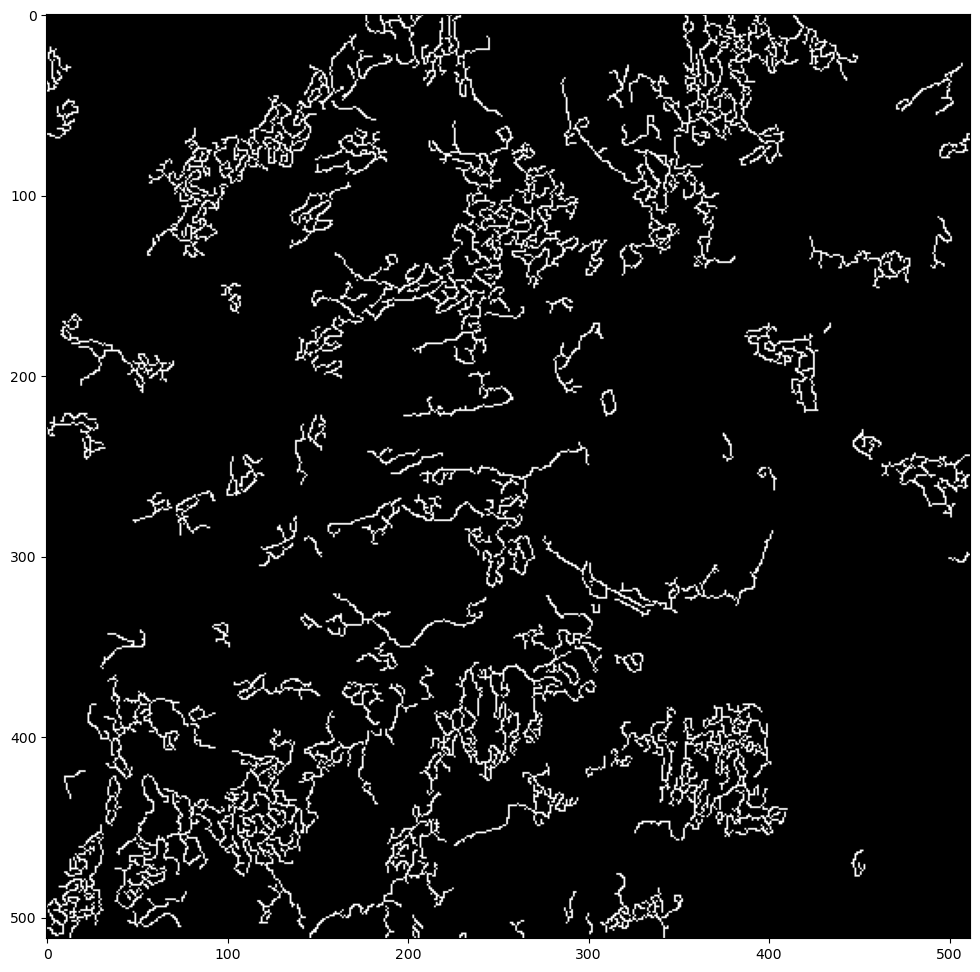

In [32]:
img = np.array(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))

# Step 1
edge_val = adaptive_canny_based_on_histogram(img)
# 显示结果
plt.figure(figsize=(12, 12))
plt.imshow(edge_val, cmap='gray')
plt.show()

In [8]:
a = torch.randn(2,1,8,8)
b = a[a>0]
print(b)
# b = torch.where(a > 0, torch.ones_like(a), torch.zeros_like(a))
# res = net(a, b, a)

tensor([2.1102, 1.3103, 0.7992, 0.4088, 1.2296, 1.0905, 0.6322, 0.4184, 0.8247,
        1.6917, 1.0700, 1.0248, 1.1570, 0.4979, 1.2112, 0.6425, 1.4970, 0.3237,
        0.1327, 0.6941, 0.7459, 0.0819, 1.3868, 0.1435, 0.1396, 1.5323, 1.9567,
        0.7444, 0.5133, 2.2285, 0.4358, 0.3078, 0.5229, 0.7844, 0.4556, 0.5025,
        0.2255, 0.4696, 0.6225, 0.4591, 0.1203, 0.9220, 0.1654, 0.3400, 0.0649,
        0.5707, 1.4084, 0.3273, 1.1778, 1.4349, 0.0527, 0.5083, 0.6482, 0.1633,
        2.1091, 0.4166, 0.9005, 0.8474, 0.0488, 0.9188, 1.1511, 1.1487, 1.3815,
        0.3323, 0.4772, 0.8125, 0.4830, 0.0471, 0.9214, 0.9302, 0.3158, 0.2626,
        1.0464, 0.8121, 1.2791])


In [ ]:
a = torch.randn(3,3)
print(a)
b = torch.max(torch.ones, a-0.5)
print(b)

tensor([[ 0.4185,  0.7608, -1.2776],
        [ 0.4659, -2.2789,  0.7965],
        [ 0.7872, -0.4419,  0.6714]])


TypeError: max() received an invalid combination of arguments - got (float, Tensor), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
